# Load, correct and analyse 🐛

In [1]:
# need to import data using combo of prelim_correct wormindex load_extract and the load_data function from prelim_analysedata
# i think best is to change wormindex function to output the dataframe of timeseries data
# having added those columns from traj to timeseries
# include only the good worm indexes (from unique 1st two, and then remove if frames <200)

# then can call this function from within the load_data function in prelim_analyse data


# use goodtrajs to keep only those two good indexes per worm
# if either of the goodindexes has less than 100 frames, then dont keep it either

# then get big concatenated dataframe (use load data function in analyse data ipynb for this)
# create new column: worm number, which identifies uniquely each worm within video within condition.
# so for mock should have 1-29, avsv 1-32, sexc 1-16

## Stuff that needs importing📥

In [2]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statistics import mean, median

%load_ext jupyter_black

## Functions ⨏

### 🧩  Functions: general & data loading

#### Function to get pathnames ⨏🏔

In [3]:
# function to get the names of file paths
def get_file_paths(root_folder, filename):
    file_paths = []
    for folder_name, subfolders, filenames in os.walk(root_folder):
        for fname in filenames:
            if fname == filename:
                file_paths.append(os.path.join(folder_name, fname))

    return file_paths

#### Function to extract only desired data ⨏🛢

In [4]:
def import_extract(filepath_metadata_featuresN):
    # print("filepath_metadata_featuresN: ", filepath_metadata_featuresN)
    # import data

    timedata = pd.read_hdf(filepath_metadata_featuresN, "/timeseries_data")
    trajdata = pd.read_hdf(filepath_metadata_featuresN, "/trajectories_data")

    # if there is no manual wormindex then keep wormindex from timeseries,
    # and use was_skeletonized to put into usual "has skeleton" column
    if "worm_index_manual" not in trajdata.columns:
        trajectories = pd.DataFrame(
            {
                "worm_id": timedata["worm_index"],
                "has_skeleton": trajdata["was_skeletonized"],
                "frame_number": trajdata["frame_number"],
                "x": trajdata["coord_x"],
                "y": trajdata["coord_y"],
            }
        )

    # if there is a manual worm index in traj file then keep that instead of wormindex
    else:
        trajectories = pd.DataFrame(
            {
                "worm_id": trajdata["worm_index_manual"],
                "has_skeleton": trajdata["has_skeleton"],
                "frame_number": trajdata["frame_number"],
                "x": trajdata["coord_x"],
                "y": trajdata["coord_y"],
            }
        )
    trajectories = pd.concat(
        [
            trajectories,
            timedata[timedata.iloc[:, 3:].dropna(axis="columns", how="all").columns],
        ],
        axis=1,
    )

    # keep only the data that has good skeletons
    trajectories = trajectories[trajectories["has_skeleton"] == 1]

    # from that, keep only the data corresponding to the first two worm ids, which are the 2 good ones
    trajectories = trajectories[
        trajectories["worm_id"].isin(trajectories["worm_id"].unique()[0:2])
    ]

    # from that, keep only data of those ids if they have at least 100 frames
    frame_cutoff = 100
    longtrajectories = (
        pd.DataFrame()
    )  # this will contain only the trajectories if they pass the longer than framecutoff rule
    for i in range(
        len((trajectories["worm_id"].unique()[0:2]))
    ):  # cycle through 0 to 1 or just 0 if only one index
        a = trajectories["worm_id"].unique()[
            i
        ]  # get object that is of the wormid column only those = first index
        length_a = (trajectories["worm_id"] == a).sum()  # check how long it is
        if length_a > frame_cutoff:  # if a is greater than framecutoff then keep it
            longtrajectories = pd.concat(
                [
                    longtrajectories,
                    trajectories[
                        trajectories["worm_id"] == trajectories["worm_id"].unique()[i]
                    ],
                ]
            )

    return longtrajectories  # which is actutruey mostly timeseries df but have inserted some things from trajectories df

#### Function to organise loading all data ⨏🗄

In [5]:
# input args: df with pathnames
# output is
# bigdict = {"fpath": {"cond": "sexc", "data": pd.DataFrame()}}
# bigdf = one big data frame will all worms all conditions.
# has added column "cond" (mock/avsv/sexc) and "filename" (corresponds to videoname)


def organise_data(pathname_dict):
    bigdf = pd.DataFrame()
    bigdict = dict()
    for key, val in pathname_dict.items():
        for i in range(len(pathname_dict[key])):
            # assign pathname to key in new bigdict
            bigdict[pathname_dict[key][i]] = dict()
            # save cond within bigdict type cond
            bigdict[pathname_dict[key][i]]["cond"] = key
            # load and save data within bigdict type data
            bigdict[pathname_dict[key][i]]["data"] = import_extract(
                pathname_dict[key][i],
            )
            # access dataframes within data type and create new columns for name and for cond
            bigdict[pathname_dict[key][i]]["data"]["cond"] = key
            bigdict[pathname_dict[key][i]]["data"]["filename"] = pathname_dict[key][i]

            # now append this new dataframe into dataframe with all data
            bigdf = pd.concat([bigdf, bigdict[pathname_dict[key][i]]["data"]])

    return bigdf, bigdict

#### Function to check consecutive numbers ⨏ 1 2 3#

In [6]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)

### 🔍 Functions: find & clean reversals, forward runs, and omegas

#### Function to find reversals ⨏🔎↩️

In [7]:
def findreversals(worm_frame_speed):
    revStartInd = []  # empty lists
    revEndInd = []

    reversals = worm_frame_speed.index[worm_frame_speed["speed"] < 0]
    # print("reversals: ", reversals)
    # reversal is list of indexs of all frames with neg speed

    # first get two lists with start and end idexes of reversals
    # then will check within reversal, if there is jump in frame split in two reversals,
    # if there are less than 15 nans and neg then count as one

    # go through each element of reversals ie all the indexes with neg speed
    # and pull out start and end indices
    for r in reversals:
        # print("r is", r)
        #### now start going through and checking
        # count first revindex as start of reversal,
        # if next is pos/nan also count as end of reversal
        if r == np.min(reversals):
            revStartInd.append(r)
            if worm_frame_speed.loc[r + 1]["speed"] >= 0 or pd.isna(
                worm_frame_speed.loc[r + 1]["speed"]
            ):
                revEndInd.append(r)
                # print("appended", r, "to revendind")

        # if the index is not 0 and is not last check whether previous&last indexs have positive speed
        elif (r > np.min(reversals)) & (r < np.max(reversals)):
            #####CHECK PREV ROW#####
            # if speed in prev row is greater than 0
            if worm_frame_speed.loc[r - 1]["speed"] >= 0 or pd.isna(
                worm_frame_speed.loc[r - 1]["speed"]
            ):
                revStartInd.append(r)
                # print("appended", r, "to revstartind")

            #####CHECK NEXT ROW#####
            # if speed in next row is greater than 0 or nan
            if worm_frame_speed.loc[r + 1]["speed"] >= 0 or pd.isna(
                worm_frame_speed.loc[r + 1]["speed"]
            ):
                revEndInd.append(r)
                # print("appended", r, "to revendind")

        # if neg speed at last negative speed index count it as end of last reversal
        # if prev was positive/nan count as start of reversal
        elif r == np.max(reversals):
            revEndInd.append(r)

            if worm_frame_speed.loc[r - 1]["speed"] >= 0 or pd.isna(
                worm_frame_speed.loc[r - 1]["speed"]
            ):
                revStartInd.append(r)
                # print("appended", r, "to revstartind")

    # check same number of rev start and end
    if len(revStartInd) != len(revEndInd):
        print("PROBLEM: revstart and revend indices don't match up :O find rev")

    return revStartInd, revEndInd

#### Function to clean reversals + calculate length ⨏🛁↩️ + 📏↩️

In [8]:
# now clean reversal start/end indices and calculate reversal lengths
def cleanreversals(worm_frame_speed, revStartInd, revEndInd):
    # create empty lists to hold output
    clean_revStartInd = []
    clean_revEndInd = []

    # first check frames within this reversal
    for l in range(len(revStartInd)):
        ##first assess whether there are any frames missing in this reversal
        # print("l", l)
        # print("len revEndInd", len(revEndInd))
        # print("len revStartInd", len(revStartInd))
        # length in index counts of this reversal
        this_revlenI = revEndInd[l] - revStartInd[l]

        # print("revEndInd[l]", revEndInd[l])
        # print("revStartInd[l]", revStartInd[l])

        # length in frames of this reversal
        this_revlenF = (
            worm_frame_speed.loc[revEndInd[l], "frame_number"]
            - worm_frame_speed.loc[revStartInd[l], "frame_number"]
        )

        # append start and end indices of reversal to clean dfs, then see if need to add any
        clean_revStartInd.append(revStartInd[l])
        clean_revEndInd.append(revEndInd[l])

        # if frame and index count dont match then check how many frames missing and if consecutive
        if this_revlenI != this_revlenF:
            # do consec analysis
            # get list of frame numbers between those two indexes
            this_rev_frames = worm_frame_speed.loc[
                revStartInd[l] : revEndInd[l], "frame_number"
            ].tolist()
            rev_cc_array = consecutive(this_rev_frames)

            for i in range(len(rev_cc_array)):
                # print("i is cycle inside len of cc array", i)
                # print("rev_cc_array[i]", rev_cc_array[i])
                # start at i=1 because first reversal break happens between 0 and 1
                if i > 0:
                    revbreakend = rev_cc_array[i][0]
                    revbreakstart = rev_cc_array[i - 1][-1]
                    revbreaklen = revbreakend - revbreakstart
                    # if reversal breakend is greater than max_frames_missing, append the frame of where rev break starts to be new revend ind
                    # and frame of where rev break ends to be new revstart ind
                    if revbreaklen > max_frames_missing + 1:
                        clean_revEndInd.append(
                            worm_frame_speed[
                                worm_frame_speed["frame_number"] == revbreakstart
                            ].index[0]
                        )
                        clean_revStartInd.append(
                            worm_frame_speed[
                                worm_frame_speed["frame_number"] == revbreakend
                            ].index[0]
                        )

    # now check frames between reversals
    for l in range(len(revStartInd)):
        # dont need to check what came before first reversal, is definitely rev start
        # if is 2nd revstart or later, check interval between previous rev end and this
        # want only frames that are in interval hence +1 and -1 after the revendind and revstartind
        if l > 0:
            # pull out interval of reversal (includes revstart and revend)
            this_interval = worm_frame_speed.loc[
                (revEndInd[l - 1]) : (revStartInd[l]), ["frame_number", "speed"]
            ]
            this_intervalS = this_interval["speed"]
            # get the the number of frames between last revend and this revstart
            this_intervalF = this_interval["frame_number"]
            this_intervalF = this_intervalF.iloc[-1] - this_intervalF.iloc[0]
            # if interval between reversals is all nans AND 4 frames or less
            if all(this_intervalS.iloc[1:-1].isna()) and this_intervalF <= (
                max_frames_missing + 1
            ):
                # then get rid of revEndInd[l - 1] and revStartInd[l]
                clean_revStartInd.remove(revStartInd[l])
                clean_revEndInd.remove(revEndInd[l - 1])

    # sort lists to make sure added frames are true in order
    clean_revStartInd.sort()
    clean_revEndInd.sort()

    # check same number of rev start and end
    if len(clean_revStartInd) != len(clean_revEndInd):
        print("PROBLEM: revstart and revend indices don't match up :O")

    # calculate reversal length
    revstart_frames = worm_frame_speed.loc[clean_revStartInd, "frame_number"].tolist()
    revend_frames = worm_frame_speed.loc[clean_revEndInd, "frame_number"].tolist()
    rev_lengths = np.array(revend_frames) - np.array(revstart_frames)
    rev_lengths += 1
    rev_lengths = rev_lengths.tolist()

    # print("revStartInd", revStartInd)
    # print("revEndInd", revEndInd)
    # print("clean_revStartInd", clean_revStartInd)
    # print("clean_revEndInd", clean_revEndInd)
    # print("rev_lengths", rev_lengths)

    return clean_revStartInd, clean_revEndInd, rev_lengths

#### Function to find fwd runs ⨏🔎⬆️

In [9]:
def findfwdruns(worm_frame_speed):
    # empty lists
    fwdStartInd = []
    fwdEndInd = []

    # NB forwards contains all indexes with positive or 0 speed, whereas reversals contains only indexes with neg speed
    forwards = worm_frame_speed.index[worm_frame_speed["speed"] >= 0]

    # print("forwards: ", forwards)
    # forwards is list of indexes of all frames with neg speed

    # first get two lists with start and end idexes of forward runs
    # then will check within forward run, if there is jump in frame split in two forward runs,
    # if there are less than 15 nans and pos speed again then count as one

    # go through each element of forwards ie all the indexes with pos or 0 speed
    # and pull out start and end indices

    for r in forwards:
        # print("r is", r)
        #### now start going through and checking
        # count first fwdindex as start of fwdrun,
        # then check if there is a next - could be first and last, in which case append also to endind
        # if there is next and is neg/nan also count as end of fwdrun (dont count as end of fwd run if its 0)
        if r == np.min(forwards):
            fwdStartInd.append(r)
            # print("appended", r, "to fwdstartind")

            if r == np.max(forwards):
                fwdEndInd.append(r)
            elif r < np.max(forwards):
                if worm_frame_speed.loc[r + 1]["speed"] < 0 or pd.isna(
                    worm_frame_speed.loc[r + 1]["speed"]
                ):
                    fwdEndInd.append(r)
                    # print("appended", r, "to fwdendind")

        # if the index is not 0 and is not last check whether previous&last indexs have negative speed
        elif (r > np.min(forwards)) & (r < np.max(forwards)):
            #####CHECK PREV ROW#####
            # if speed in prev row is smaller than 0 or nan
            if worm_frame_speed.loc[r - 1]["speed"] < 0 or pd.isna(
                worm_frame_speed.loc[r - 1]["speed"]
            ):
                fwdStartInd.append(r)
                # print("appended", r, "to fwdstartind")

            #####CHECK NEXT ROW#####
            # if speed in next row is smaller than 0 or nan
            if worm_frame_speed.loc[r + 1]["speed"] < 0 or pd.isna(
                worm_frame_speed.loc[r + 1]["speed"]
            ):
                fwdEndInd.append(r)
                # print("appended", r, "to fwdendind")

        # if pos speed at last forward speed index, count it as end of last fwd run
        # if prev was negative/nan count also as start of fwd run
        elif r == np.max(forwards):
            fwdEndInd.append(r)
            # print("appended", r, "to fwdendind")

            if worm_frame_speed.loc[r - 1]["speed"] < 0 or pd.isna(
                worm_frame_speed.loc[r - 1]["speed"]
            ):
                fwdStartInd.append(r)
                # print("appended", r, "to fwdstartind")

    # check same number of rev start and end
    if len(fwdStartInd) != len(fwdEndInd):
        print(
            "PROBLEM: fwdstart and fwdend indices don't match up :O (find fwdruns function)"
        )

    # print("fwdStartInd", fwdStartInd)
    # print("fwdEndInd", fwdEndInd)

    return fwdStartInd, fwdEndInd

#### Function to clean fwd runs + calculate length ⨏🛁⬆️ + 📏⬆

In [10]:
# clean forward run start/end indices and calculate fwdrun lengths
def cleanfwdruns(worm_frame_speed, fwdStartInd, fwdEndInd):
    # create empty lists to hold output
    clean_fwdStartInd = []
    clean_fwdEndInd = []

    # first check frames within this fwd run
    for l in range(len(fwdStartInd)):
        ##first assess whether there are any frames missing in this fwdrun
        # print("l", l)
        # print("len fwdEndInd", len(fwdEndInd))
        # print("len fwdStartInd", len(fwdStartInd))
        # length in index counts of this fwdrun
        this_fwdlenI = fwdEndInd[l] - fwdStartInd[l]

        # print("fwdEndInd[l]", fwdEndInd[l])
        # print("fwdStartInd[l]", fwdStartInd[l])

        # length in frames of this fwd run
        this_fwdlenF = (
            worm_frame_speed.loc[fwdEndInd[l], "frame_number"]
            - worm_frame_speed.loc[fwdStartInd[l], "frame_number"]
        )

        # append start and end indices of fwd run to clean dfs, then see if need to add any
        clean_fwdStartInd.append(fwdStartInd[l])
        clean_fwdEndInd.append(fwdEndInd[l])

        # if frame and index count dont match then check how many frames missing and if consecutive
        if this_fwdlenI != this_fwdlenF:
            # do consecutive analysis
            # get list of frame numbers between those two indexes
            this_fwd_frames = worm_frame_speed.loc[
                fwdStartInd[l] : fwdEndInd[l], "frame_number"
            ].tolist()
            fwd_cc_array = consecutive(this_fwd_frames)

            for i in range(len(fwd_cc_array)):
                # print("i is cycle inside len of cc array", i)
                # print("fwd_cc_array[i]", fwd_cc_array[i])
                # start at i=1 because first fwdrun break happens between 0 and 1
                if i > 0:
                    fwdbreakend = fwd_cc_array[i][0]
                    fwdbreakstart = fwd_cc_array[i - 1][-1]
                    fwdbreaklen = fwdbreakend - fwdbreakstart
                    # if fwd run breakend is greater than max_frames_missing, append the frame of where fwd break starts to be new fwdend ind
                    # and frame of where fwd break ends to be new fwdstart ind
                    if fwdbreaklen > max_frames_missing + 1:
                        clean_fwdEndInd.append(
                            worm_frame_speed[
                                worm_frame_speed["frame_number"] == fwdbreakstart
                            ].index[0]
                        )
                        clean_fwdStartInd.append(
                            worm_frame_speed[
                                worm_frame_speed["frame_number"] == fwdbreakend
                            ].index[0]
                        )

    # now check frames between fwd runs
    for l in range(len(fwdStartInd)):
        # dont need to check what came before first fwd run, is definitely fwd start
        # if is 2nd fwd run or later, check interval between previous fwd end and this fwd start
        # want only frames that are in interval hence -1 after the fwdendind
        if l > 0:
            # pull out interval of fwd run (includes fwdstart and fwdend)
            this_interval = worm_frame_speed.loc[
                (fwdEndInd[l - 1]) : (fwdStartInd[l]), ["frame_number", "speed"]
            ]
            this_intervalS = this_interval["speed"]
            # get the the number of frames between last fwdend and this fwdstart
            this_intervalF = this_interval["frame_number"]
            this_intervalF = this_intervalF.iloc[-1] - this_intervalF.iloc[0]
            # if interval between fwd runs is all nans AND 4 frames or less
            if all(this_intervalS.iloc[1:-1].isna()) and this_intervalF <= (
                max_frames_missing + 1
            ):
                # then get rid of fwdEndInd[l - 1] and fwdStartInd[l]
                clean_fwdStartInd.remove(fwdStartInd[l])
                clean_fwdEndInd.remove(fwdEndInd[l - 1])

    # sort lists to make sure added frames are all in order
    clean_fwdStartInd.sort()
    clean_fwdEndInd.sort()

    # check same number of fwd start and end
    if len(clean_fwdStartInd) != len(clean_fwdEndInd):
        print("PROBLEM: fwdstart and fwdend indices don't match up :O")

    # calculate fwd run length
    fwdstart_frames = worm_frame_speed.loc[clean_fwdStartInd, "frame_number"].tolist()
    fwdend_frames = worm_frame_speed.loc[clean_fwdEndInd, "frame_number"].tolist()
    fwd_lengths = np.array(fwdend_frames) - np.array(fwdstart_frames)
    fwd_lengths += 1
    fwd_lengths = fwd_lengths.tolist()

    # print("fwdStartInd", fwdStartInd)
    # print("fwdEndInd", fwdEndInd)
    # print("clean_fwdStartInd", clean_fwdStartInd)
    # print("clean_fwdEndInd", clean_fwdEndInd)
    # print("fwd_lengths", fwd_lengths)

    return clean_fwdStartInd, clean_fwdEndInd, fwd_lengths

#### function to remove reversals too short or too long 🚫↩️👶🏻👨🏼‍🦳

In [11]:
# min and max length for considering as reversals
# minrevlen = 15
# maxrevlen = 80


def exclude_short_long_revs(data_df):
    # make copy of data_df to work on within function
    infunct_data_df = data_df.copy()

    # add allrevstart and allrevend columns to infunct_data_df
    infunct_data_df["TrueRevStart"] = False
    infunct_data_df["TrueRevEnd"] = False

    # will contain rev len lists and unique id list matching length to create new true_rev_lengths
    revlengs_ids = []
    revlengs = []
    true_rev_lengths = []

    wormlist = infunct_data_df["unique_id"].unique()

    # cycle within each worm
    for worm in wormlist:
        # list to hold lists of true reversal lengths
        this_worm_tRLg = []

        this_worm = infunct_data_df[infunct_data_df["unique_id"] == worm].copy()

        # get list with revstart and revend indices = true
        revstarts = this_worm[this_worm["RevStart"] == True].index.tolist()
        revends = this_worm[this_worm["RevEnd"] == True].index.tolist()

        # cycle within the list of revstart = true indices
        for R in range(len(revstarts)):
            # for each revstart, check how many frames between revstart and next revend
            # R is position in list of revstarts
            # fstart is start and end frames of
            fstart = this_worm.loc[revstarts[R], "frame_number"]
            fend = this_worm.loc[revends[R], "frame_number"]
            this_rev_len = fend - fstart + 1

            # if 15<this_rev_len<80
            # add revstart and revend to truerevstart and truerevend columns
            # add revlen to new_rev_lengths
            if this_rev_len > minrevlen and this_rev_len < maxrevlen:
                infunct_data_df.loc[revstarts[R], "TrueRevStart"] = True
                infunct_data_df.loc[revends[R], "TrueRevEnd"] = True

                this_worm_tRLg.append(this_rev_len)

        # to store reversal lengths
        # cycle thrugh list of reversal lengths and append worm id to worm id list and rev leng to rev list
        # then will join both these lists into df
        for k in this_worm_tRLg:
            revlengs_ids.append(worm)
            revlengs.append(k)

    infunct_data_df.rename(
        columns={
            "RevStart": "ogRevStart",
            "RevEnd": "ogRevEnd",
            "TrueRevStart": "RevStart",
            "TrueRevEnd": "RevEnd",
        },
        inplace=True,
    )

    # now create true_rev_lengths
    # thisdf will contain unique worm id (short) as 1st column and the length of each reversal in 2nd column
    true_rev_lengths = pd.DataFrame()
    true_rev_lengths = true_rev_lengths.assign(unique_id=revlengs_ids, revlen=revlengs)

    return infunct_data_df, true_rev_lengths

#### function to correct misidentified heads in reversals ⨏🔄👶🏻🐛

In [12]:
def correct_misheads(corrected_data_df, head_errors_list):
    # add this column which will show whether worm has had head corrected or not
    corrected_data_df["mishead"] = False

    for index, row in head_errors_list.iterrows():
        # get some values specific to this worm
        this_worm = head_errors_list.loc[index, "unique_id_long"]
        print("this_worm ie long", this_worm)
        print("unique id short", head_errors_list.loc[index, "unique_id"])
        this_SF = head_errors_list.loc[index, "StartFrame"]
        this_EF = head_errors_list.loc[index, "EndFrame"]
        # find start and end index of the stretch to be corrected
        startindex = corrected_data_df[
            (corrected_data_df["unique_id_long"] == this_worm)
            & (corrected_data_df["frame_number"] == this_SF)
        ].index[0]
        endindex = corrected_data_df[
            (corrected_data_df["unique_id_long"] == this_worm)
            & (corrected_data_df["frame_number"] == this_EF)
        ].index[0]

        # select this stretch in dataframe and replace with inverse values
        corrected_data_df.loc[startindex:endindex, "speed"] = -corrected_data_df.loc[
            startindex:endindex, "speed"
        ]

        # change value of "mishead" column to true to indicate this worm has had its head misidentified and thus speed corrected
        corrected_data_df.loc[
            corrected_data_df["unique_id"] == this_worm, "mishead"
        ] = True

        print(
            "unique id short from new dataset",
            corrected_data_df.loc[
                (corrected_data_df["unique_id_long"] == this_worm)
                & (corrected_data_df["frame_number"] == this_SF),
                "unique_id",
            ],
        )

    return corrected_data_df

#### function to find (inferred) omega turns ⨏Ω↺

In [13]:
minomegalength = 20
maxomegalength = 400

# draft find omega turns function


def findomegas(data_df):
    # NB omega start frame is last frame of rev, omega end frame is next frame in worm (cant label missing frame!)

    # create 2 new columns in datadf: omegaS, omegaE (all false)
    data_df["OmegaS"] = False
    data_df["OmegaE"] = False

    # create 4 lists: omega_startindex, omegalengths, revlengths (nb revlenghts contains only the lenght of reversals followed by omega), unique_id
    omega_startindex = []
    omega_startframes = []
    omega_lengths = []
    omega_revlengths = []
    omega_ids = []

    # cycle through each worm
    worms = data_df["unique_id"].unique().tolist()
    for worm in worms:
        # print("worm", worm)
        this_worm = data_df[data_df["unique_id"] == worm]

        # within worm, pull out two lists of framenumber at which ogrevstart = true, and ogrevend = true
        thiswormRS = this_worm.index[this_worm["ogRevStart"] == True].tolist()
        thiswormRE = this_worm.index[this_worm["ogRevEnd"] == True].tolist()

        # print("thiswormRS", thiswormRS)
        # print("thiswormRE", thiswormRE)

        # save also the last index corresponding to this worm
        thisworm_maxindex = this_worm.index.max()

        # then cycle through list of OGREVEND frames
        for RE in thiswormRE:
            # print("RE", RE)
            # save frame number
            REframenumber = this_worm.loc[RE, "frame_number"]

            # save remainder of worm speed as smaller df
            speedseries = this_worm.loc[(RE + 1) : thisworm_maxindex, ["speed"]]
            # print("speedseries", speedseries)

            # check if speedseries is empty (this happens if reversal ends on last frame of that worm). only do the rest if is not empty (IE False)
            if speedseries.empty == False:
                # print("speedseries is not empty")
                # check if next first valid index within speedseries (ie next speed that is not nan or missing) is nan
                # if first valid index isnan is False, that means that there is a next non-nan value before end of worm
                if pd.isna(speedseries.first_valid_index()) == False:
                    # get (frame number of that index) - 1 (we want frame of last nan / missing index )
                    nextvalidindex = speedseries.first_valid_index()
                    # print("next valid index exists")

                # if first valid index isnan is True, that means that there is not a non-nan value before end of worm
                # means that na stretch runs up until the end - take last frame of series as the last frame of omega turn
                elif pd.isna(speedseries.first_valid_index()) == True:
                    nextvalidindex = speedseries.index.max()
                    # print("there is no next valid index before worm end")

                # print("nextvalidindex", nextvalidindex)

                # get omega start and end framenumber & index
                # (omega starts at last frame of  rev )
                omegastartframe = this_worm.loc[(RE), "frame_number"]
                omegastartindex = RE

                omegaendframe = this_worm.loc[(nextvalidindex), "frame_number"]
                omegaendindex = nextvalidindex

                # print("omegastartframe", omegastartframe)
                # print("omegaendframe", omegaendframe)

                # omegalength is not plus one bc we have taken start frame to be last frame of rev
                omegalength = omegaendframe - omegastartframe
                # print("omegalength", omegalength)

                # if omegalength is between 20-400 we consider an omega turn (try then with 80)
                if omegalength >= minomegalength and omegalength <= maxomegalength:
                    # add start and end trues to omegaS and omegaE
                    data_df.loc[omegastartindex, "OmegaS"] = True
                    data_df.loc[omegaendindex, "OmegaE"] = True

                    # calculate length of preceeding reversal, from ogrevstart & ogrevend frame got at beggining
                    thisrevnumber = thiswormRE.index(RE)
                    thisrevstartI = thiswormRS[thisrevnumber]
                    thisrevendI = thiswormRE[thisrevnumber]
                    thisrevstartF = this_worm.loc[thisrevstartI, "frame_number"]
                    thisrevsendF = this_worm.loc[thisrevendI, "frame_number"]

                    thisrevlen = thisrevsendF - thisrevstartF + 1

                    # add omega starti, omega length,  revlength and wormid of this omega turn to corresponding 4 lists
                    omega_startindex.append(omegastartindex)
                    omega_startframes.append(omegastartframe)
                    omega_lengths.append(omegalength)
                    omega_revlengths.append(thisrevlen)
                    omega_ids.append(worm)

            # else:
            # print("speedseries is empty")

    omegas = pd.DataFrame(
        list(
            zip(
                omega_ids,
                omega_lengths,
                omega_revlengths,
                omega_startindex,
                omega_startframes,
            )
        ),
        columns=[
            "unique_id",
            "omega_length",
            "omega_revlength",
            "omega_startindex",
            "omega_startframe",
        ],
    )
    # print("omega_lengths", omega_lengths)
    # print("omega_revlengths", omega_revlengths)
    # print("omega_ids", omega_ids)

    return omegas

### 🔪Functions: data cleaning (general)

#### function to remove worms with scant frames ⨏🚫💩🐛

In [14]:
def remove_shitty_worms(data_df):
    wormlist = data_df["unique_id"].unique()
    max_frames = data_df["frame_number"].max()
    good_worms = []
    for worm in wormlist:
        this_worm_speed = data_df["speed"][data_df["unique_id"] == worm]
        this_worm_gf = this_worm_speed.count()
        this_worm_gf_percent = (this_worm_gf / max_frames) * 100
        if this_worm_gf_percent > min_good_frames_percent:
            good_worms.append(worm)

    updated_data_df = data_df[data_df["unique_id"].isin(good_worms)].copy()

    return updated_data_df

### 🤓Functions: extract data parameters

#### function to count good frames in each worm ⨏✅🎞

In [15]:
# function to check missing data
# input is data_df
# output is df with uniqueid, total frames that are not nan, percentage, and color code


def count_good_frames(data_df):
    gf_per_worm = pd.DataFrame(pd.Series(wormlist, name="unique_id"))
    gf_per_worm["good_frames"] = pd.NA

    # add column with color corresponding to condition (for plotting)
    # create lists with unique_ids of each worm condition
    mock_worms = data_df["unique_id"][data_df["cond"] == "mock"].unique().tolist()
    avsv_worms = data_df["unique_id"][data_df["cond"] == "avsv"].unique().tolist()
    sexc_worms = data_df["unique_id"][data_df["cond"] == "sexc"].unique().tolist()

    for worm in wormlist:
        this_worm_speed = data_df["speed"][data_df["unique_id"] == worm]
        this_worm_gf = this_worm_speed.count()
        gf_per_worm.loc[gf_per_worm["unique_id"] == worm, "good_frames"] = this_worm_gf

        if worm in mock_worms:
            gf_per_worm.loc[gf_per_worm["unique_id"] == worm, "color_cond"] = "#a8a9a8"
            gf_per_worm.loc[gf_per_worm["unique_id"] == worm, "cond"] = "mock"

        elif worm in avsv_worms:
            gf_per_worm.loc[gf_per_worm["unique_id"] == worm, "color_cond"] = "#87da4b"
            gf_per_worm.loc[gf_per_worm["unique_id"] == worm, "cond"] = "avsv"

        elif worm in sexc_worms:
            gf_per_worm.loc[gf_per_worm["unique_id"] == worm, "color_cond"] = "#ef8e93"
            gf_per_worm.loc[gf_per_worm["unique_id"] == worm, "cond"] = "sexc"

    # add column with percentage of good frames per worm
    max_frames = data_df["frame_number"].max()
    gf_per_worm["percent_good"] = (gf_per_worm["good_frames"] / max_frames) * 100
    gf_per_worm = gf_per_worm.reindex(
        columns=["color_cond", "cond", "unique_id", "good_frames", "percent_good"]
    )

    return gf_per_worm
    # gf_per_worm is dataframe with 4 cols:
    # unique_id,
    # number of good frames that worm has,
    # percentage of good frames (frames / max frames across all conds),
    # color code corresponding to condition

#### function to calculate feats. per min per worm: reversals and omegas ⨏↩️Ω⏱🐛

In [16]:
def calculate_ROPW(gf_per_worm, rev_lengths, omegas):
    feats_per_worm = gf_per_worm.copy()
    feats_per_worm["totalR"] = 0
    feats_per_worm["totalO"] = 0
    for i in rev_lengths["unique_id"].unique():
        feats_per_worm.loc[feats_per_worm["unique_id"] == i, "totalR"] = rev_lengths[
            "unique_id"
        ].value_counts()[i]

    for j in omegas["unique_id"].unique():
        feats_per_worm.loc[feats_per_worm["unique_id"] == j, "totalO"] = omegas[
            "unique_id"
        ].value_counts()[j]

    # Reversals per min is frames divided by 900 bc 15frames/sec and 60sec/min --> 60*15 = 900
    feats_per_worm["R/min"] = feats_per_worm["totalR"] / (
        feats_per_worm["good_frames"] / (60 * framerate)
    )

    feats_per_worm["O/min"] = feats_per_worm["totalO"] / (
        feats_per_worm["good_frames"] / (60 * framerate)
    )

    return feats_per_worm


##########OLD VERSION ONLY REV PER MIN PER WORM
# def calculate_RPW(gf_per_worm, rev_lengths):
#     feats_per_worm = gf_per_worm.copy()
#     feats_per_worm["totalR"] = 0
#     for i in rev_lengths["unique_id"].unique():
#         feats_per_worm.loc[feats_per_worm["unique_id"] == i, "totalR"] = rev_lengths[
#             "unique_id"
#         ].value_counts()[i]

#     # Reversals per min is frames divided by 900 bc 15frames/sec and 60sec/min --> 60*15 = 900
#     feats_per_worm["R/min"] = feats_per_worm["totalR"] / (
#         feats_per_worm["good_frames"] / (60 * framerate)
#     )

#     return feats_per_worm

### 🎨 Functions: plotting

#### function to organise traj data to call plotter function ⨏🗺📍


In [55]:
def organise_indv_traj_plot(all_data, outputdir):
    # set some constants
    min_x = 0
    max_x = 46000
    min_y = 0
    max_y = 46000
    fig, ax = plt.subplots()
    # cycle through all worms
    for worm in wormlist:
        this_worm = all_data[all_data["unique_id"] == worm]
        cond = all_data["cond"][all_data["unique_id"] == worm].unique().tolist()[0]
        wormstr = np.array2string(worm)
        thisx = this_worm["coord_x_body"]
        thisy = this_worm["coord_y_body"]
        thisframe = this_worm["frame_number"]
        this_filename = outputdir + cond + wormstr + ".eps"

        this_cmap = "viridis"
        # now plot trajectory of this worm using above variables

        plot_traj(
            thisx,
            thisy,
            thisframe,
            this_cmap,
            min_x,
            max_x,
            min_y,
            max_y,
            this_filename,
        )
    return

#### function to make pretty trajectory plots ⨏🎨📍

In [56]:
def plot_traj(xvals, yvals, frames, this_cmap, minx, maxx, miny, maxy, filename):
    fig, ax = plt.subplots()
    ax.scatter(xvals, yvals, s=0.1, c=frames, cmap=this_cmap, marker=".")
    ax.set_xlim(left=minx, right=maxx)
    ax.set_ylim(bottom=miny, top=maxy)

    plt.savefig(filename, transparent=True, format="eps")

    plt.show()

    return

## Inputs 🥚🧈🫐



In [19]:
## only inputs needed for the whole thingymawhatsits to run

#####################################################################


# 1. set output directory (need to make it match name of legit existing folder)
outputdirhim5 = "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/post-conditioning/him5/output_current_him5/him5_2may_getfwdrunspercentiles_4stats/"
outputdirBAR302 = "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/BAR302/11jan/"

# 2. set code to choose all other parameters and suffix (HIM-5 / BAR302)
code = "HIM-5"
# code = "BAR302"


####################################################################


if code == "HIM-5":
    outputdir = outputdirhim5

    folders = [
        "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/data_uptoDEC/Results/him5_aftercond/mock",
        "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/data_uptoDEC/Results/him5_aftercond/avsv",
        "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/data_uptoDEC/Results/him5_aftercond/sexc",
    ]

elif code == "BAR302":
    outputdir = outputdirBAR302

    folders = [
        "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/data_uptoDEC/Results/BAR302_aftercond/mock",
        "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/data_uptoDEC/Results/BAR302_aftercond/avsv",
        "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/data_uptoDEC/Results/BAR302_aftercond/sexc",
    ]

else:
    print("error in input code for condition. should be HIM-5 or BAR302")


##true other parameters are here

# enter framerate (15fps)
framerate = 15

# max frames missing - max frames that can be missing inside rev and still consider it one reversal instead of 2 (also for forward etc)
# should be 1 sec and is 15fps so 15 frames
max_frames_missing = 15

# min_good_frames_percent - maximum frames a worm can be missing to be considered for analysis - e.g. if is 30 percent worms that have less than 30% good frames excluded
min_good_frames_percent = 50

# min and max length for considering as reversals
minrevlen = 15
maxrevlen = 80

# min and max omega length
minomegalength = 45
maxomegalength = 400

## Actual code to call functions is here 📞

### Load data into massive data frame and dict 📞📥
- then correct misheads
- then remove worms with scant frame number

In [20]:
# set some variables
conds = ["mock", "avsv", "sexc"]  # condition codes to append as needed
features_filename = "metadata_featuresN.hdf5"

pathnames_dict = dict()
# loop to get a dictionary containing the  pathnames for each condition
for f in range(0, 3):
    this_path_list = get_file_paths(folders[f], features_filename)
    pathnames_dict[conds[f]] = this_path_list

del f
del this_path_list


# now have pathnames dict, need to reorganise data and keep only the bits we want
data_df, data_dict = organise_data(pathnames_dict)


# create unique ids for each worm and save xls with equivalency to worm video (uniquelongid)
data_df["unique_id_long"] = data_df["filename"] + data_df["worm_id"].astype(str)
newids = data_df["unique_id_long"].unique()
df_newids = pd.Series(newids, name="unique_id_long").reset_index()
df_newids = df_newids.rename(columns={"index": "unique_id"})
data_df = data_df.merge(df_newids, on="unique_id_long")
df_newids.to_excel(outputdir + "worm_unique_id_" + code + ".xlsx")


# ###################################################


# # call function to correct misidentified heads, only in HIM-5 condition

# if code == "HIM-5":
#     ## correct instances where head is misidentified by simply inverting sign of speed in that period
#     head_errors = pd.read_excel(
#         "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/from Milly - Excel and word files for reversals info/Reversals Errors copy.xlsx"
#     )

#     # create copies of data_df
#     temp_data_df = data_df.copy()
#     noncorrected_head_data_df = data_df.copy()
#     del data_df

#     # run function
#     corrected_data_df = correct_misheads(temp_data_df, head_errors)

#     # return corrected values to datadf and delete temp versions
#     data_df = corrected_data_df.copy()
#     del corrected_data_df, temp_data_df

#     print("heads have been corrected")

# else:
#     print("heads have not been corrected")


# ###################################################


# call function to remove worms with few frames
sheared_data_df = remove_shitty_worms(data_df)
all_worms_data_df = data_df.copy()
data_df = sheared_data_df.copy()
del sheared_data_df

/tmp/ipykernel_236/3561799082.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bigdict[pathname_dict[key][i]]["data"]["cond"] = key
/tmp/ipykernel_236/3561799082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bigdict[pathname_dict[key][i]]["data"]["filename"] = pathname_dict[key][i]
/tmp/ipykernel_236/3561799082.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi

### call  find/clean reversals, forward runs, and omegas functions📞↩️

In [21]:
# to run reversals AND forward run functions
# create list with unique wormlist
wormlist = data_df["unique_id"].unique()


# will contain rev len lists and unique id list matching length to create all_rev_lengths
revlengs_ids = []
revlengs = []

# will contain fwd run len lists and unique id list matching length to create true_fwd_lengths
fwdlengs_ids = []
fwdlengs = []


# add columns to contain fwd and rev start and end indices
data_df["RevStart"] = False
data_df["RevEnd"] = False
data_df["FwdStart"] = False
data_df["FwdEnd"] = False


for worm in wormlist:
    print("this worm: ", worm)
    this_worm_speed = data_df[["frame_number", "speed"]][data_df["unique_id"] == worm]

    # find and clean reversals
    this_worm_RS_dirty, this_worm_RE_dirty = findreversals(this_worm_speed)
    this_worm_RS, this_worm_RE, this_worm_RLg = cleanreversals(
        this_worm_speed, this_worm_RS_dirty, this_worm_RE_dirty
    )

    # find and clean fwd runs
    this_worm_FS_dirty, this_worm_FE_dirty = findfwdruns(this_worm_speed)
    this_worm_FS, this_worm_FE, this_worm_FLg = cleanfwdruns(
        this_worm_speed, this_worm_FS_dirty, this_worm_FE_dirty
    )

    # to store reversal and fwd run lengths
    # cycle thrugh list of reversal/fwdrun lengths and append worm id to worm id list and rev/fwd leng to rev/fwd list
    # then will join both these lists into df
    for k in this_worm_RLg:
        revlengs_ids.append(worm)
        revlengs.append(k)

    for m in this_worm_FLg:
        fwdlengs_ids.append(worm)
        fwdlengs.append(m)

    # now also create columns in data_df that contain true at reversal start/end points (clean)
    data_df.loc[this_worm_RS, "RevStart"] = True
    data_df.loc[this_worm_RE, "RevEnd"] = True
    data_df.loc[this_worm_FS, "FwdStart"] = True
    data_df.loc[this_worm_FE, "FwdEnd"] = True

# thisdf will contain unique worm id (short) as 1st column and the length of each reversal in 2nd column, another df same for fwdruns
all_rev_lengths = pd.DataFrame()
all_rev_lengths = all_rev_lengths.assign(unique_id=revlengs_ids, revlen=revlengs)

all_fwd_lengths = pd.DataFrame()
all_fwd_lengths = all_fwd_lengths.assign(unique_id=fwdlengs_ids, fwdlen=fwdlengs)


# now get rid of ONLY REVERSALS that are too long or too short (dont apply this to forward runs!)
# then rename the the old dataframe so still have access, but use new_data_df as data_df

new_data_df, true_rev_lengths = exclude_short_long_revs(data_df)
data_df_all_revs = data_df.copy()
del data_df
data_df = new_data_df.copy()
del new_data_df

## nowfind omega turns
omegas = findomegas(data_df)

this worm:  0
this worm:  3
this worm:  7
this worm:  8
this worm:  9
this worm:  11
this worm:  12
this worm:  14
this worm:  15
this worm:  16
this worm:  17
this worm:  18
this worm:  19
this worm:  20
this worm:  22
this worm:  23
this worm:  24
this worm:  25
this worm:  27
this worm:  28
this worm:  29
this worm:  30
this worm:  37
this worm:  39
this worm:  41
this worm:  48
this worm:  50
this worm:  51
this worm:  52
this worm:  53
this worm:  54
this worm:  57
this worm:  59
this worm:  60
this worm:  62
this worm:  63
this worm:  64
this worm:  65
this worm:  66
this worm:  67
this worm:  68
this worm:  69
this worm:  70
this worm:  71
this worm:  72
this worm:  73
this worm:  74
this worm:  75
this worm:  76
this worm:  77
this worm:  78
this worm:  80
this worm:  81
this worm:  82
this worm:  83
this worm:  84
this worm:  85
this worm:  87
this worm:  89
this worm:  91
this worm:  92
this worm:  93
this worm:  94
this worm:  95
this worm:  96
this worm:  97
this worm:  98


### call functions to calculate good_frames_per_worm,  and reversals+omegas per frame per worm

In [22]:
# first create lists with unique_ids of each worm condition
mock_worms = data_df["unique_id"][data_df["cond"] == "mock"].unique().tolist()
avsv_worms = data_df["unique_id"][data_df["cond"] == "avsv"].unique().tolist()
sexc_worms = data_df["unique_id"][data_df["cond"] == "sexc"].unique().tolist()


# count good frames
gf_per_worm = count_good_frames(data_df)


# calculate reversals per worm per minute and omegas per worm per minute
feats_per_worm = calculate_ROPW(gf_per_worm, true_rev_lengths, omegas)


# same as above but using all reversals (not just ones between 15 and 80 frames)
# # count good frames
# gf_per_worm_all_revs = count_good_frames(data_df_all_revs)

# # calculate reversals per worm per minute
# feats_per_worm_all_revs = calculate_RPW(gf_per_worm_all_revs, all_rev_lengths)
# feats_per_worm_all_revs.to_excel(
#     "feats_per_worm_all_revs.xlsx"
# )
# # to make violin plot on prism lol

### write all outputs to laptop

In [23]:
## write all to laptop
# DataFrame.to_hdf(path_or_buf, key,

data_df.to_hdf(
    outputdir + "data_df_" + code + ".h5",
    "df",
)


true_rev_lengths.to_hdf(
    outputdir + "true_rev_lengths_" + code + ".h5",
    "df",
)

true_rev_lengths.to_excel(outputdir + "true_rev_lengths_" + code + ".xlsx")


all_fwd_lengths.to_hdf(
    outputdir + "all_fwd_lengths" + code + ".h5",
    "df",
)
all_fwd_lengths.to_excel(outputdir + "all_fwd_lengths" + code + ".xlsx")


feats_per_worm.to_excel(
    outputdir + "feats_per_worm_" + code + ".xlsx"
)  # to make violin plot on prism lol
gf_per_worm.to_excel(outputdir + "gf_per_worm_" + code + ".xlsx")

omegas.to_excel(outputdir + "omegas_" + code + ".xlsx")

### call functions to plot trajectory

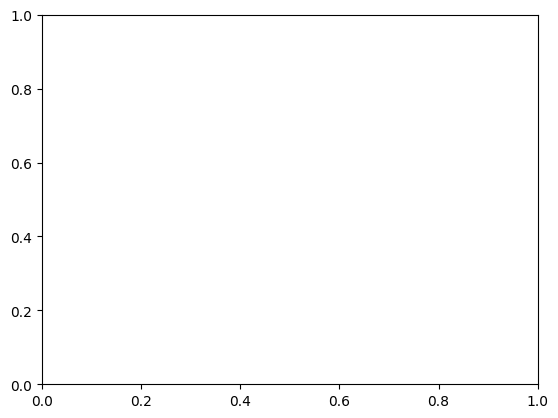

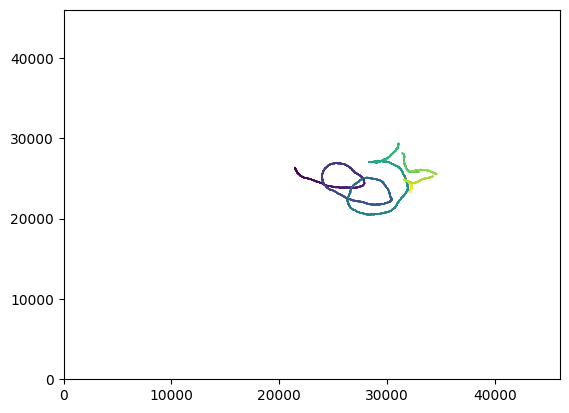

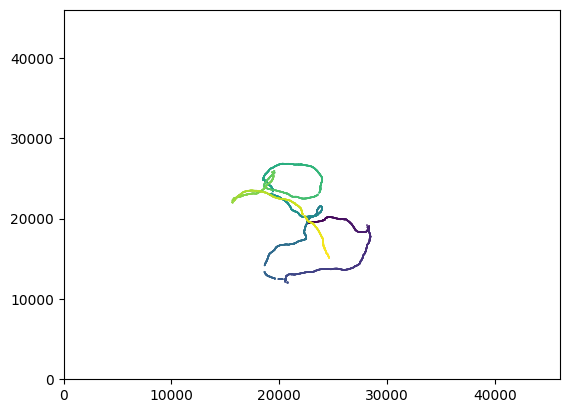

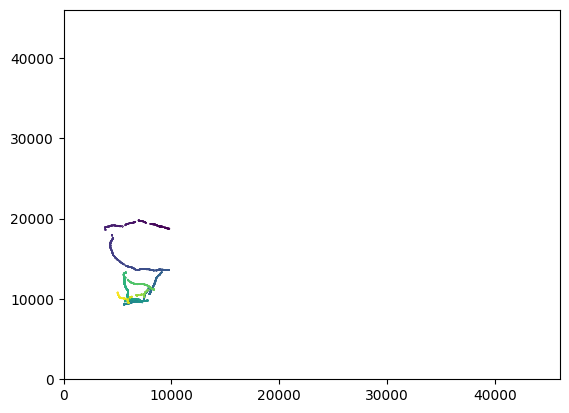

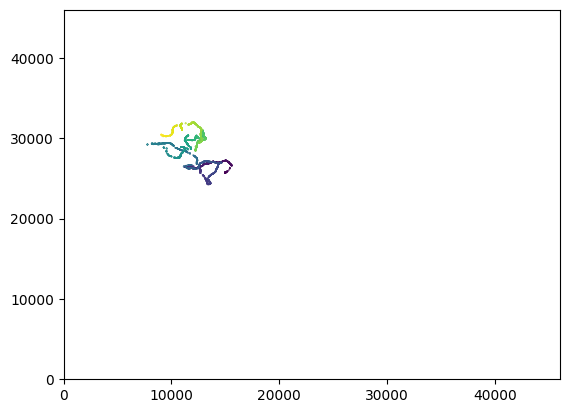

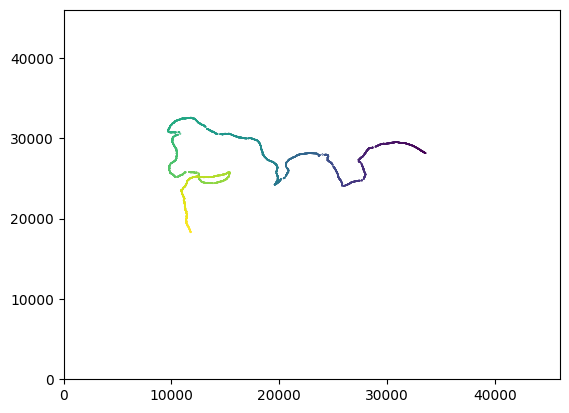

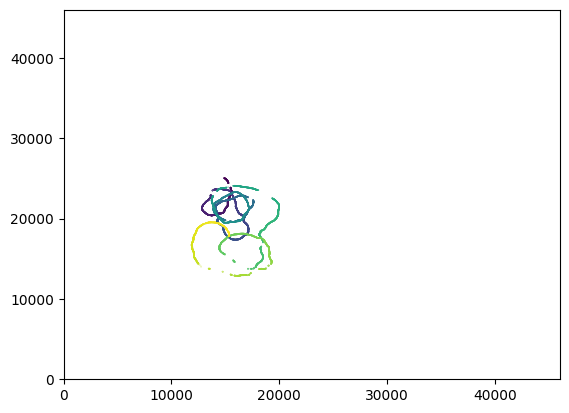

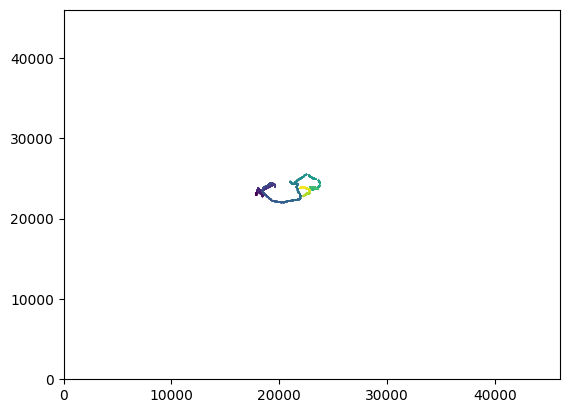

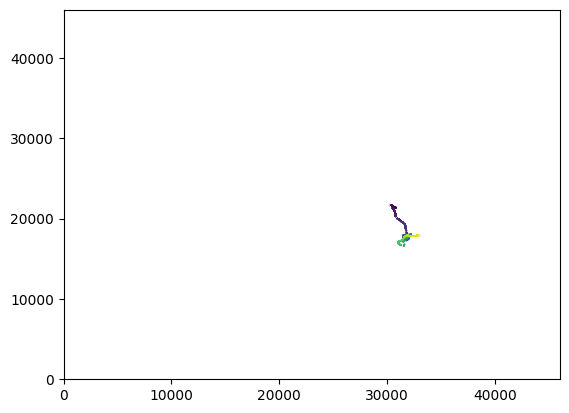

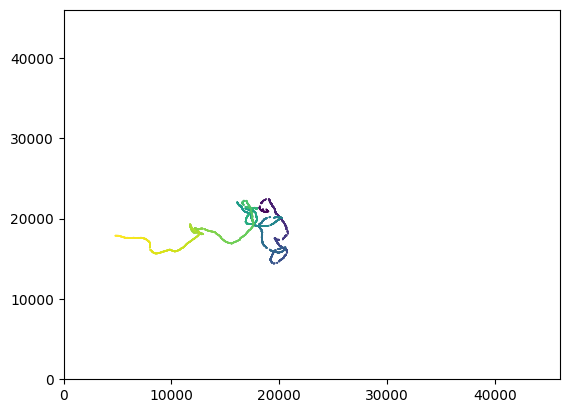

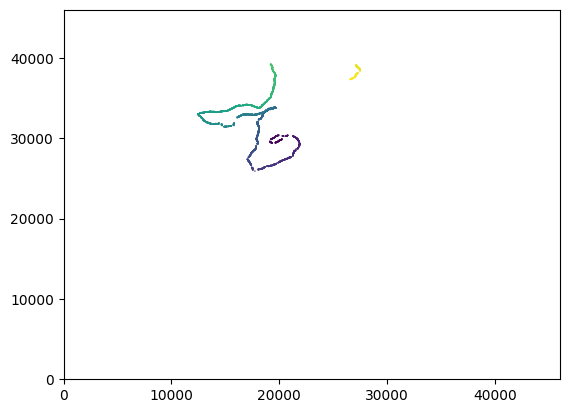

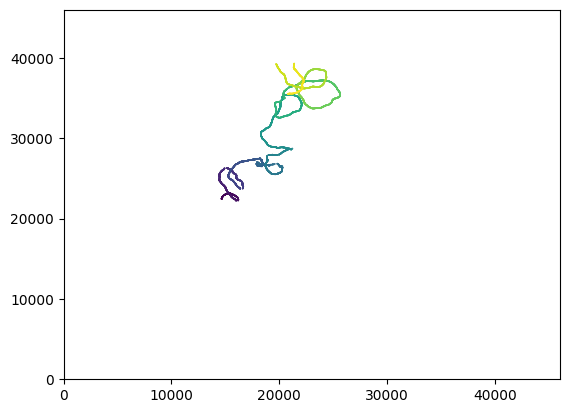

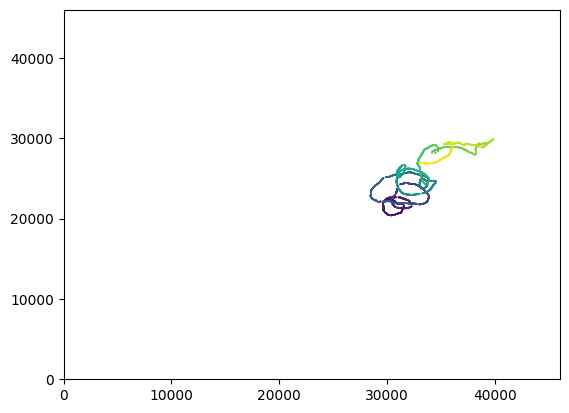

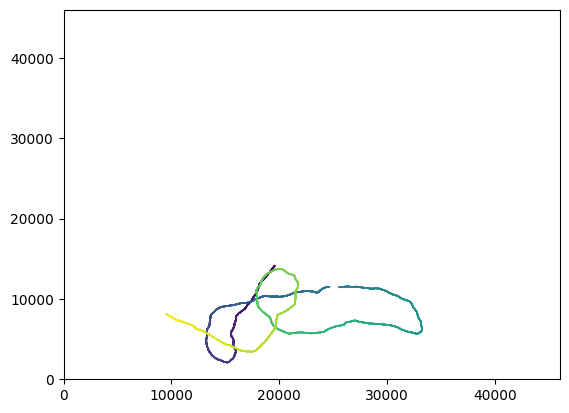

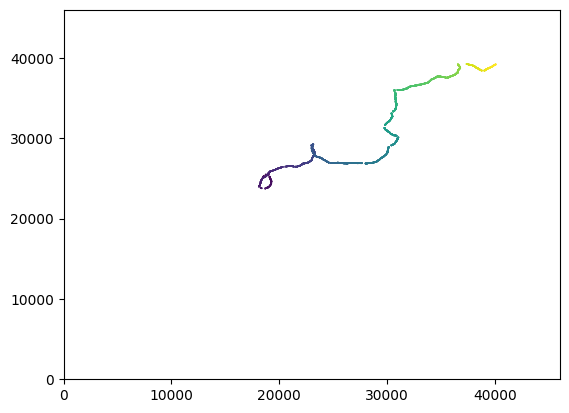

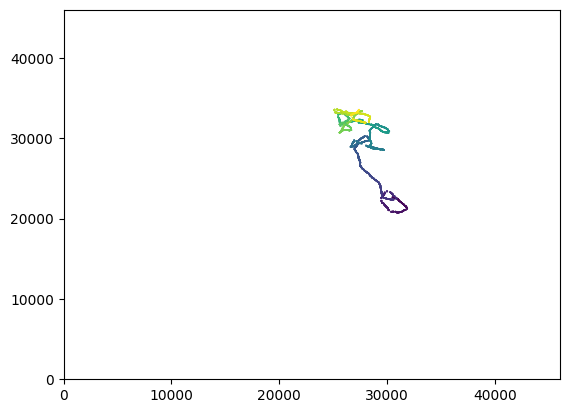

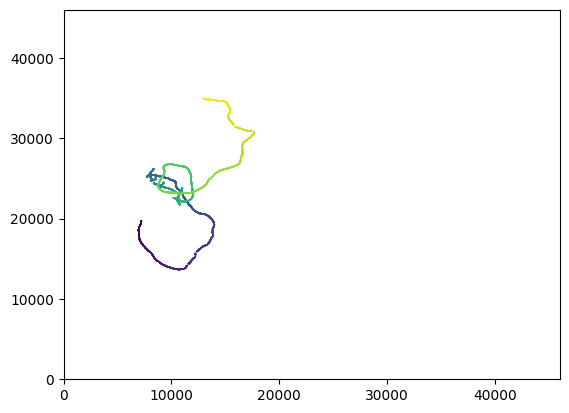

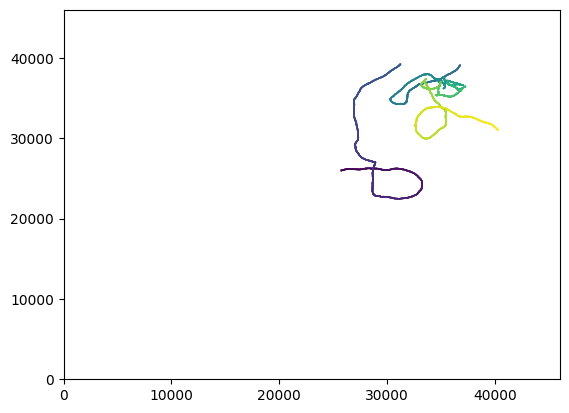

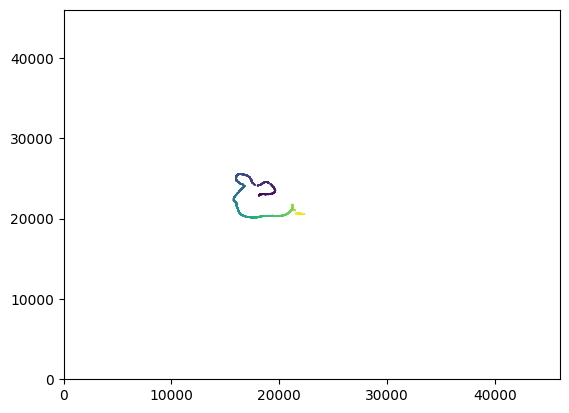

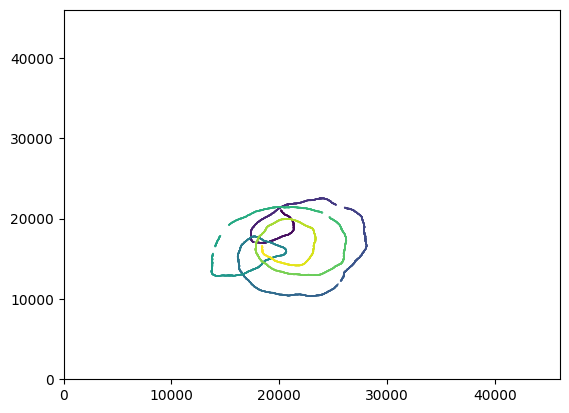

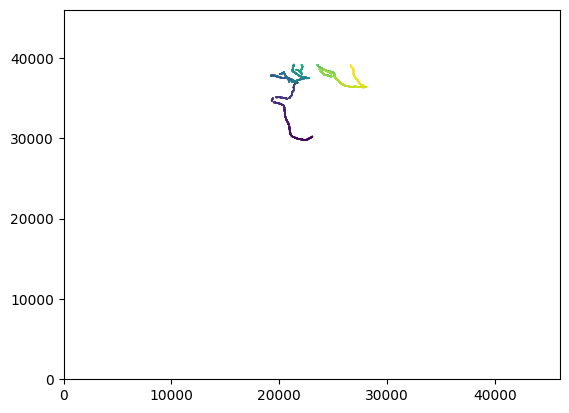

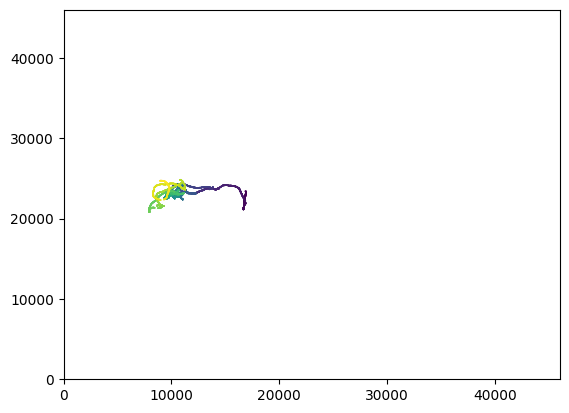

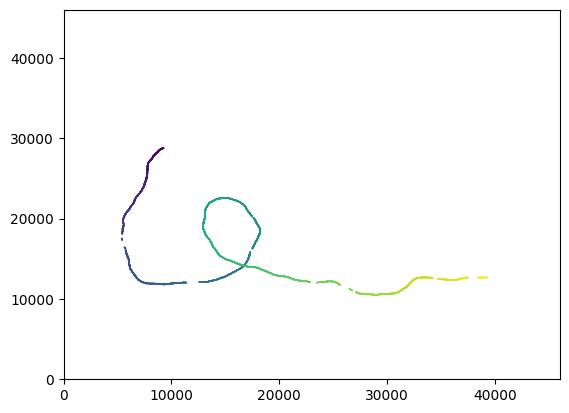

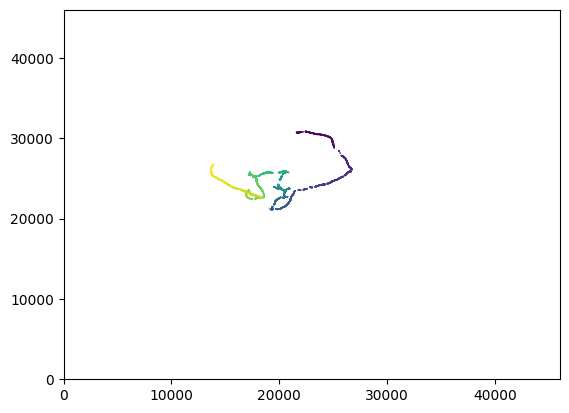

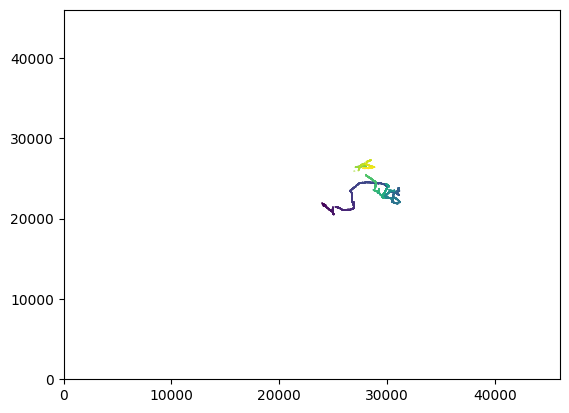

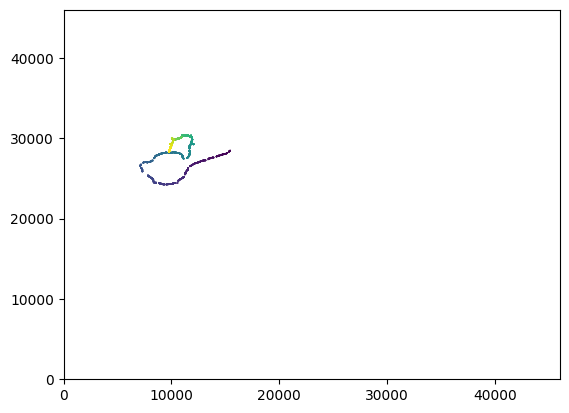

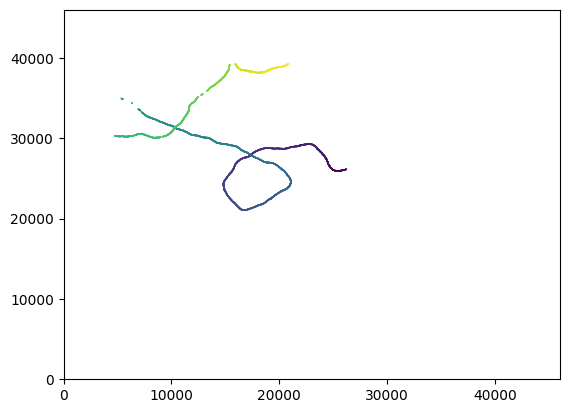

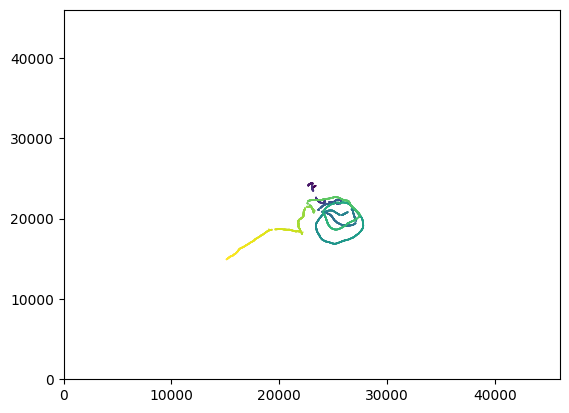

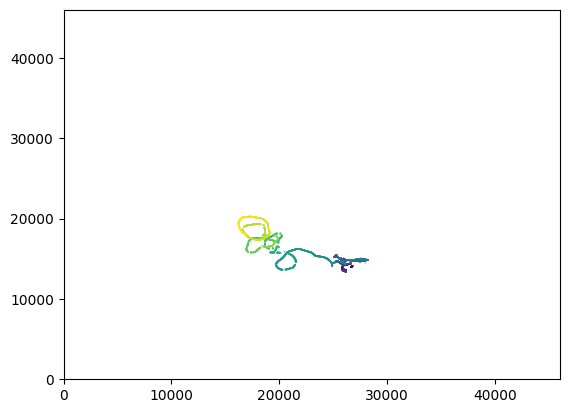

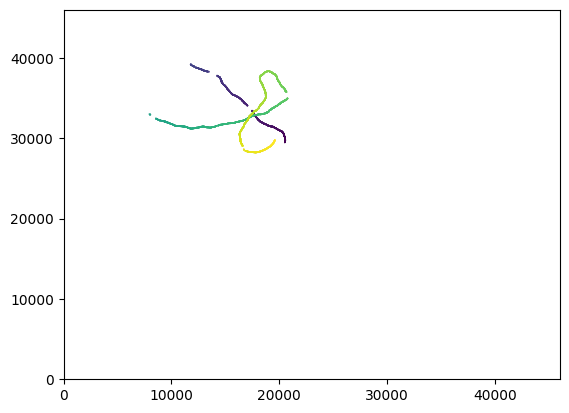

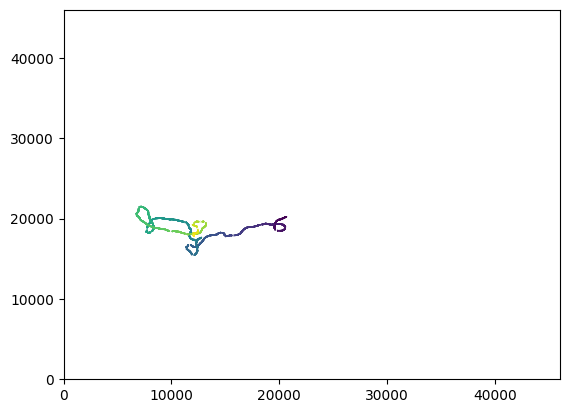

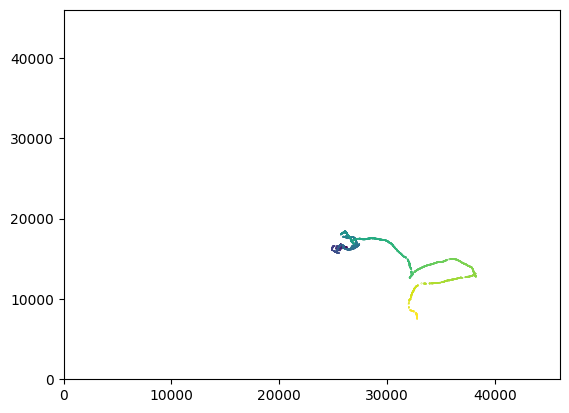

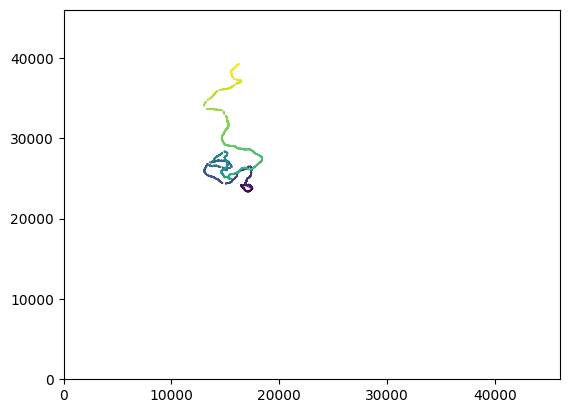

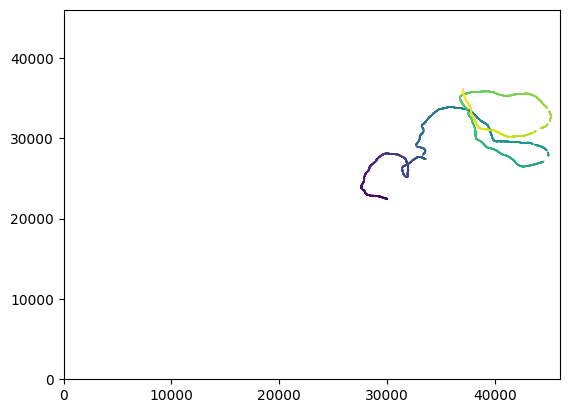

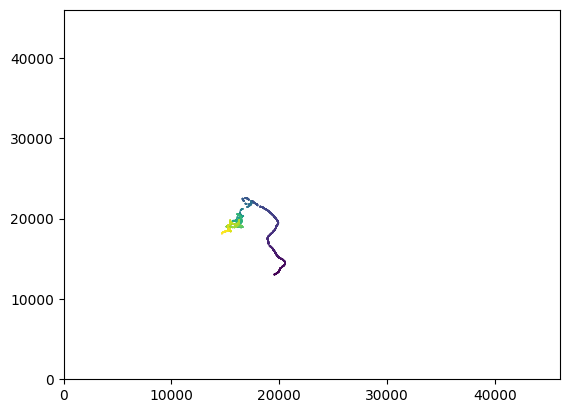

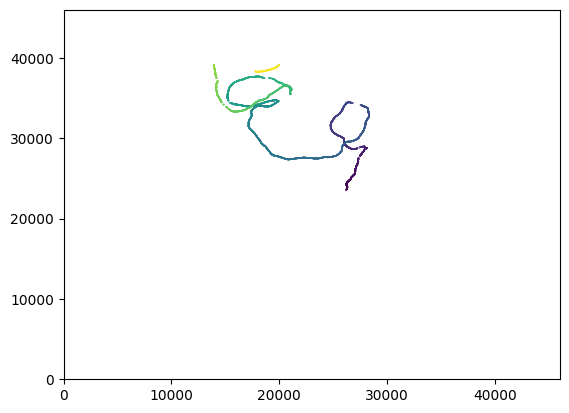

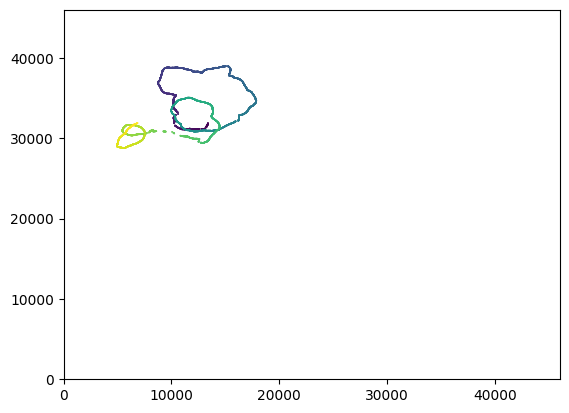

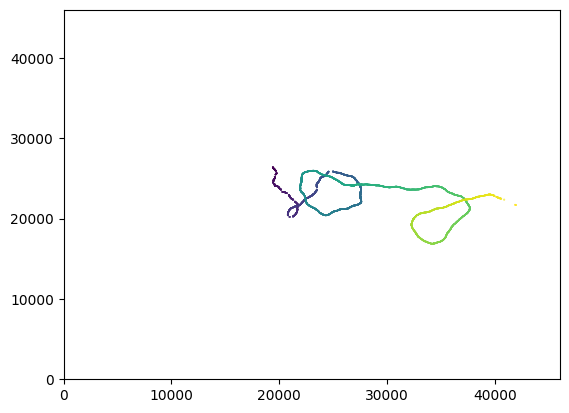

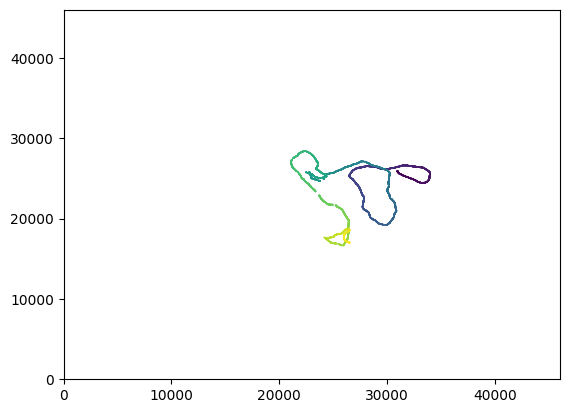

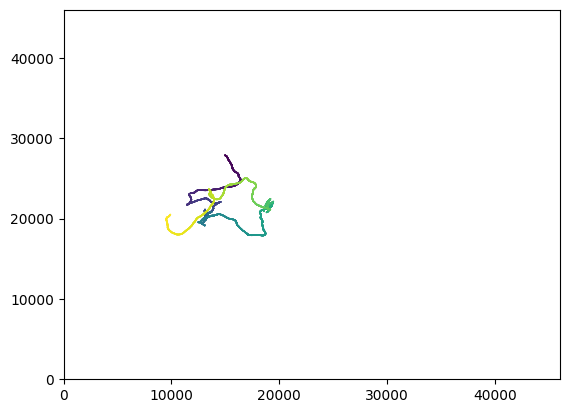

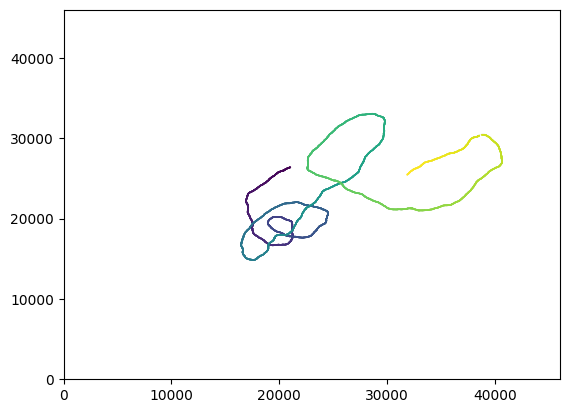

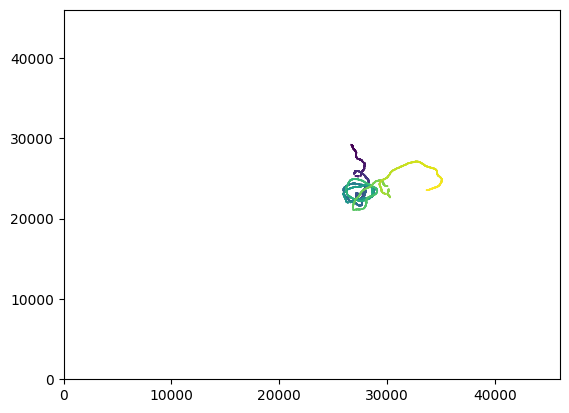

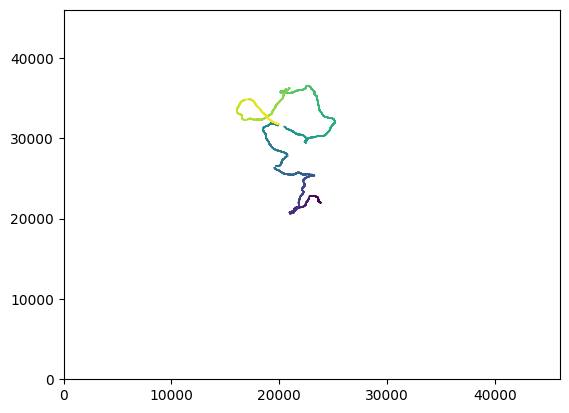

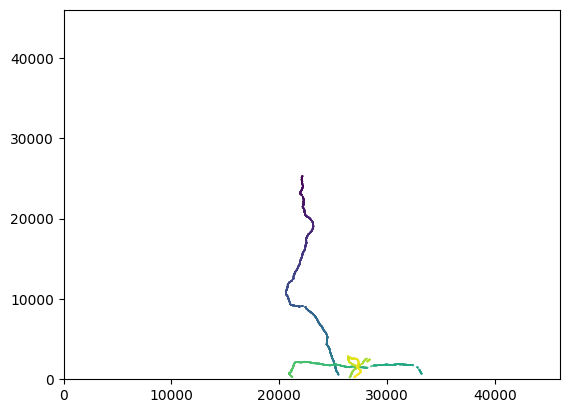

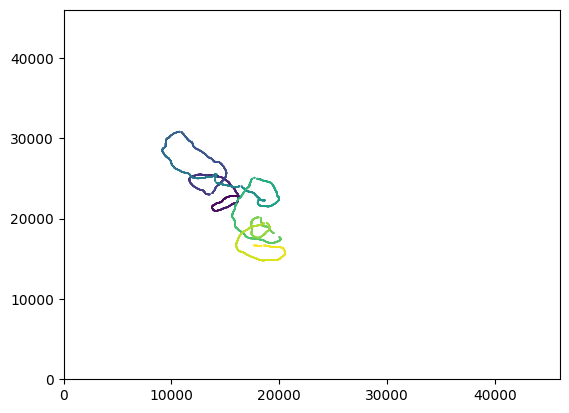

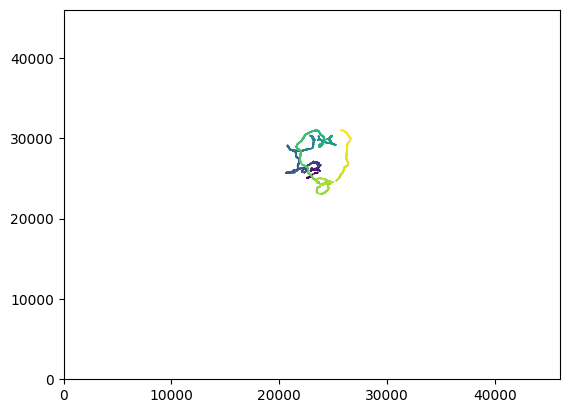

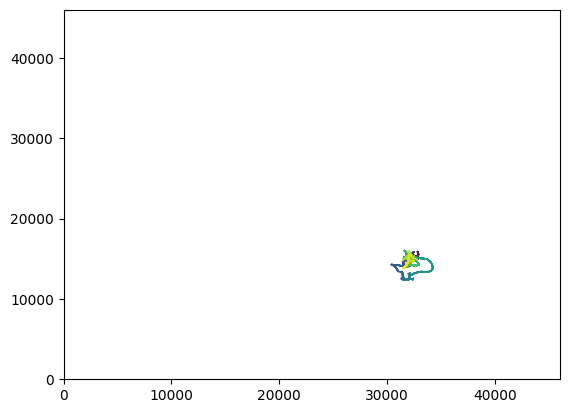

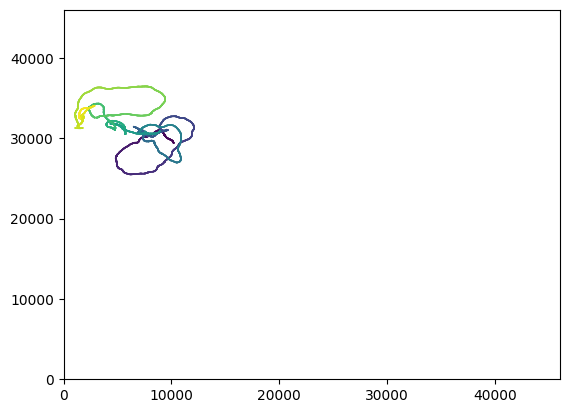

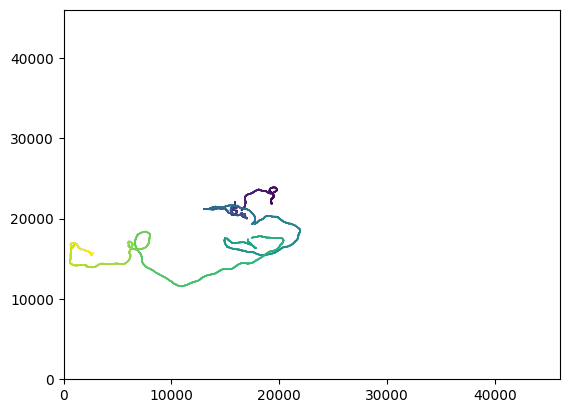

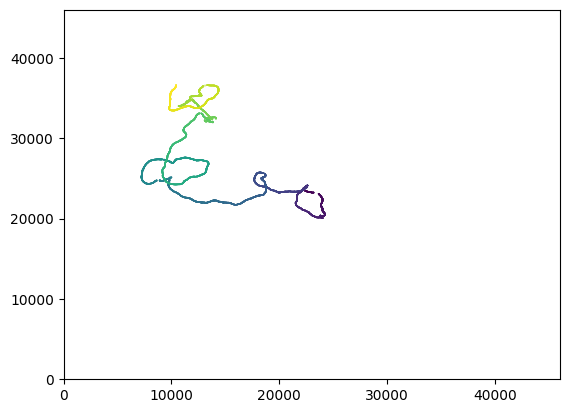

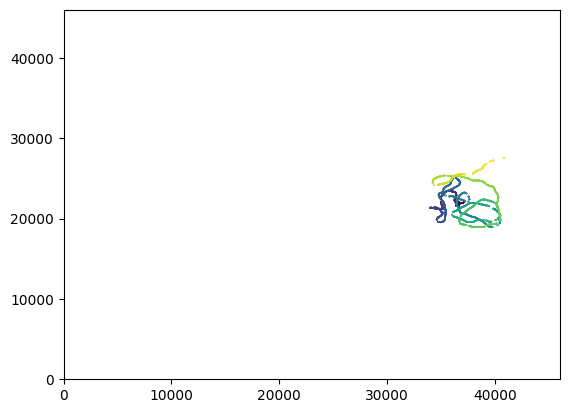

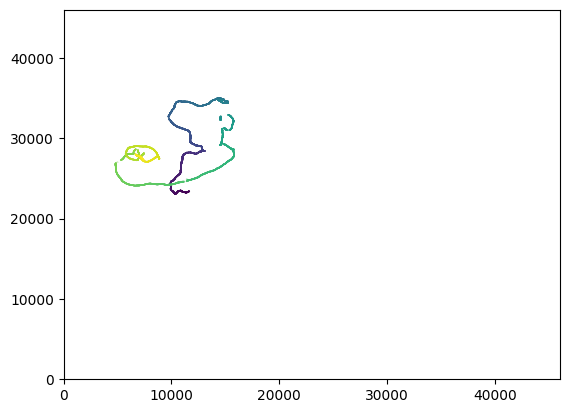

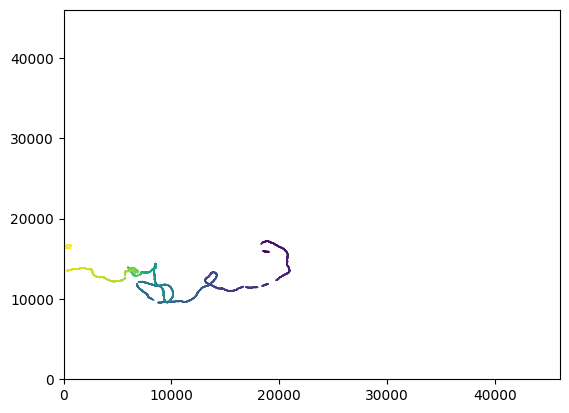

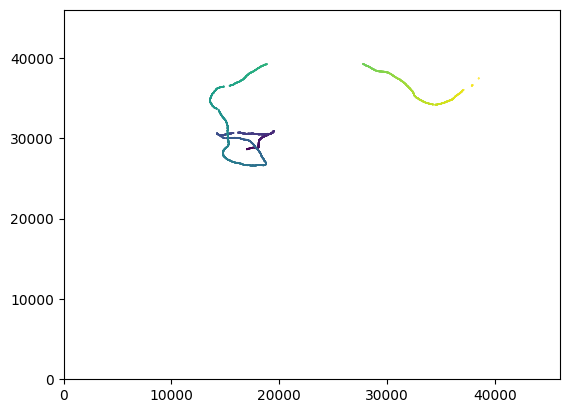

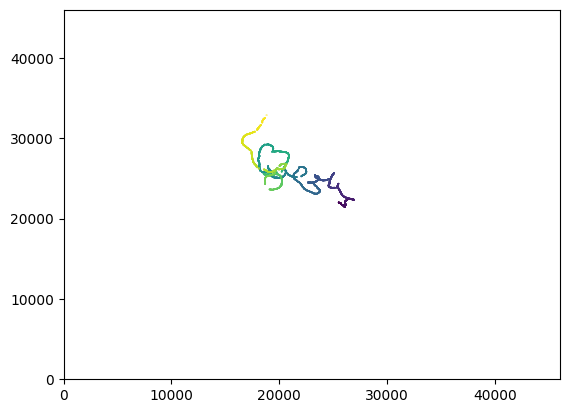

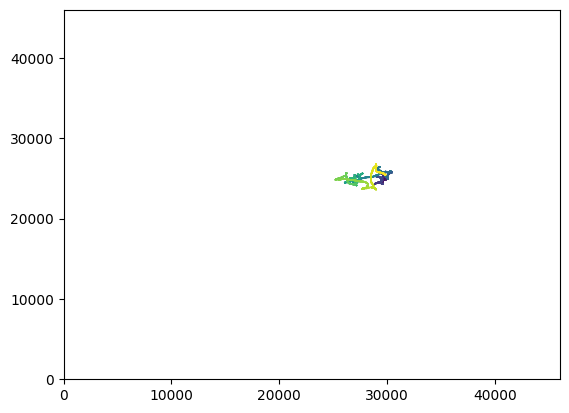

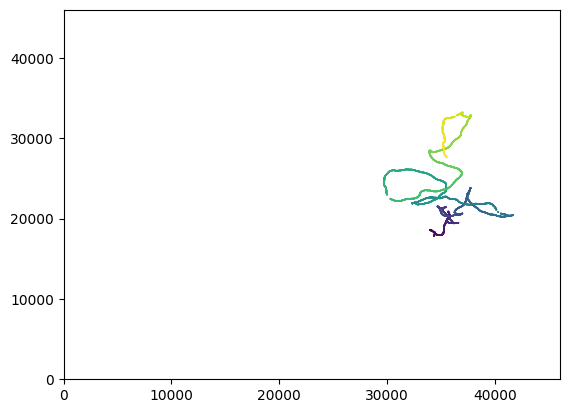

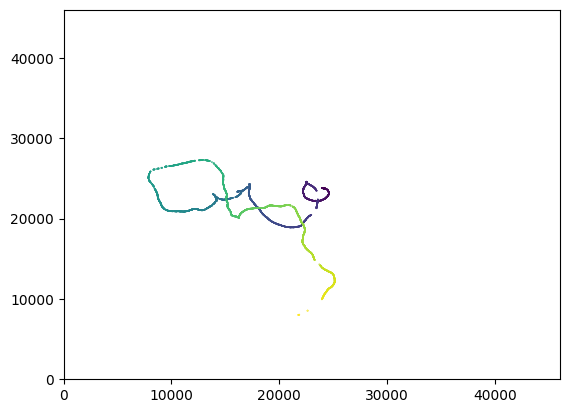

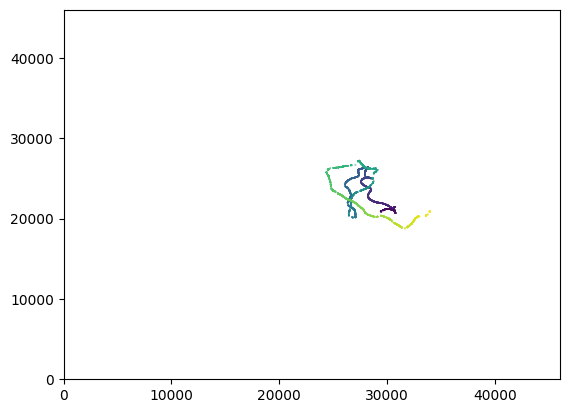

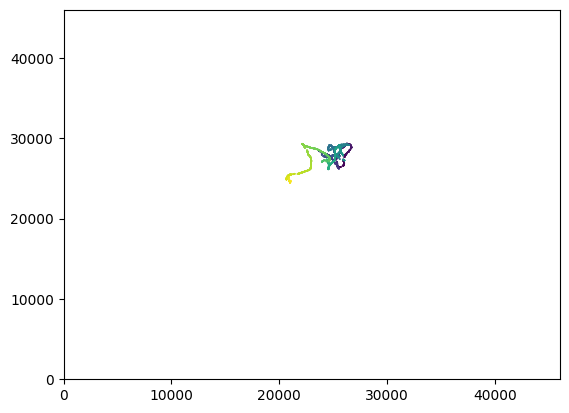

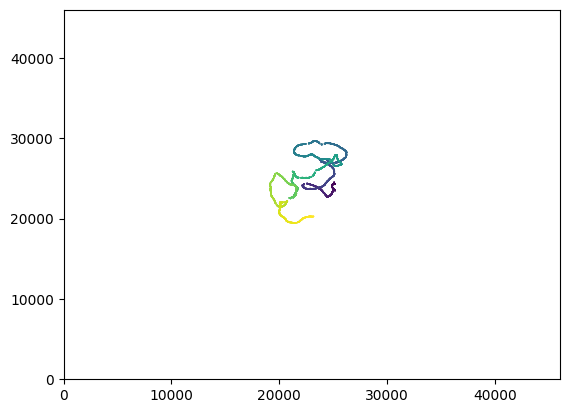

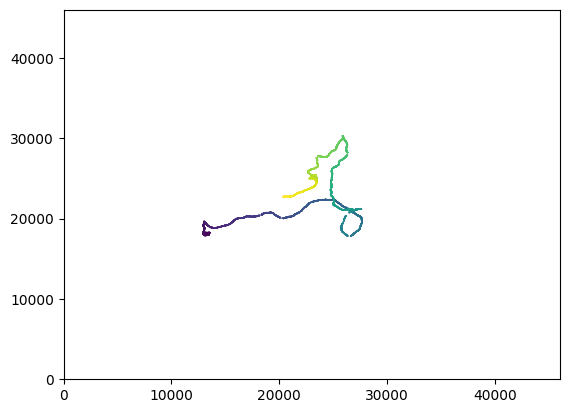

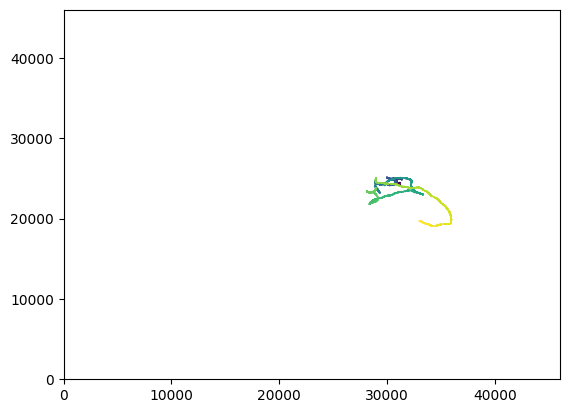

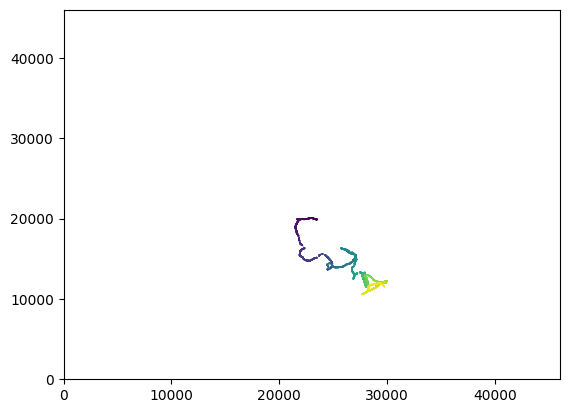

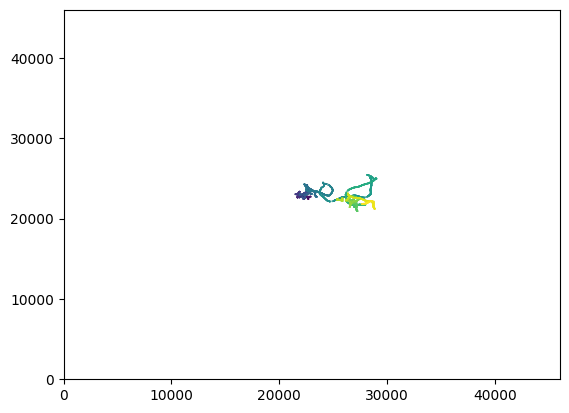

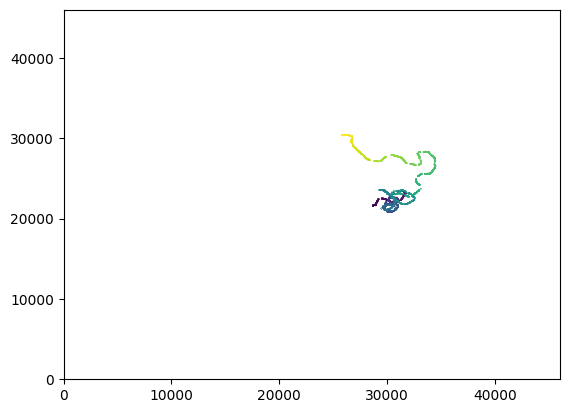

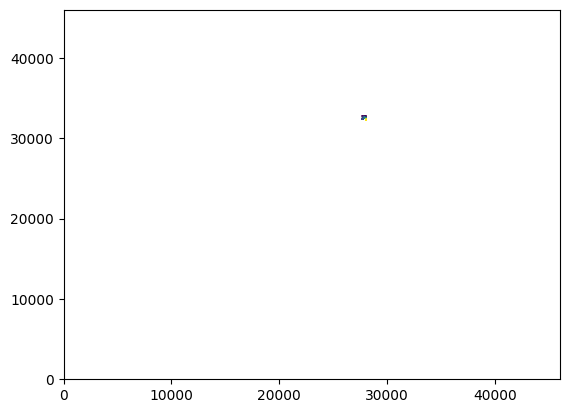

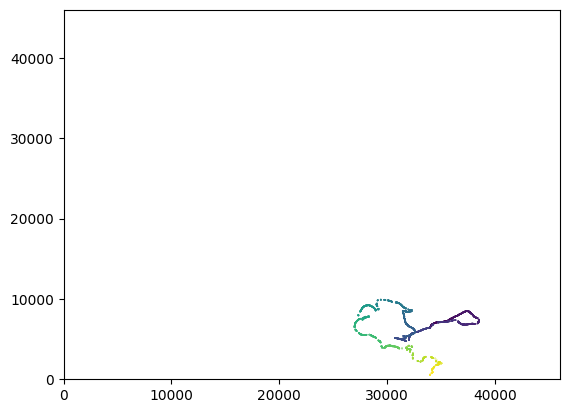

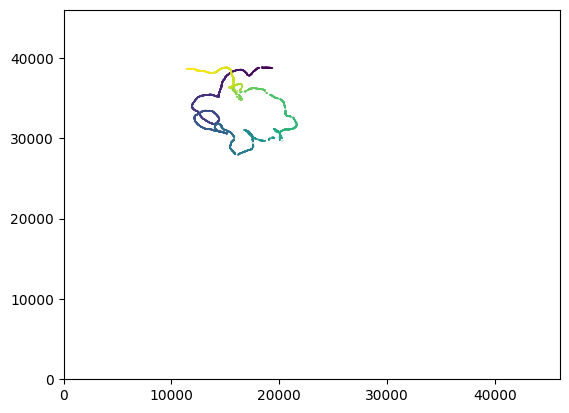

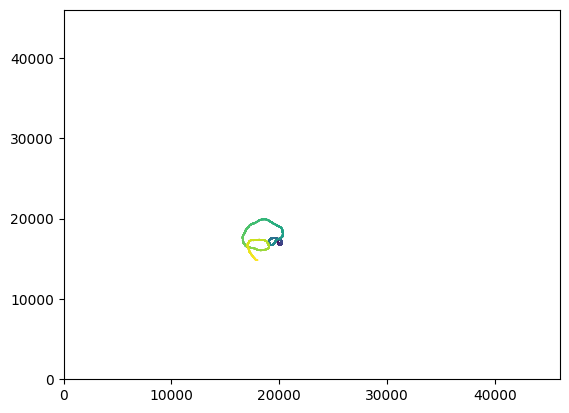

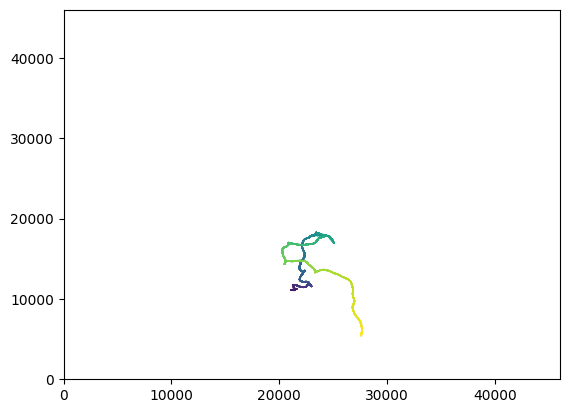

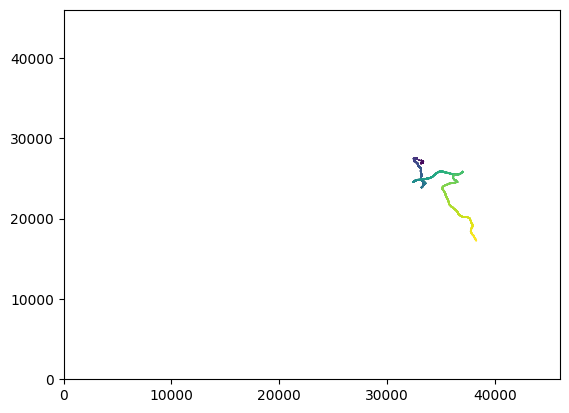

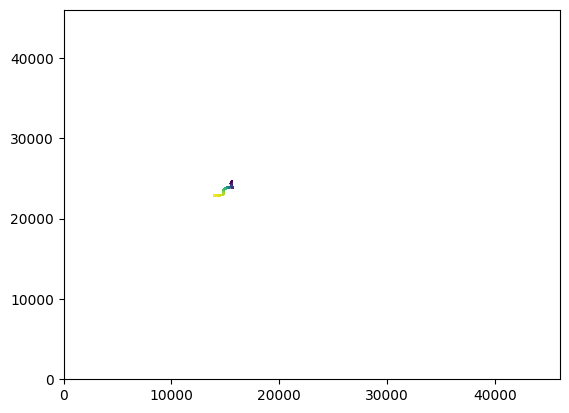

In [57]:
# call traj plots - makes one plot per worm

organise_indv_traj_plot(data_df, outputdir)
# when re-run this make sure x_coord and y_coord min and max still within range set in function

In [54]:
len(sexc_worms)

20

In [28]:
# saved sequential colormaps here
sequentials = [
    "Greys",
    "Purples",
    "Blues",
    "Greens",
    "Oranges",
    "Reds",
    "YlOrBr",
    "YlOrRd",
    "OrRd",
    "PuRd",
    "RdPu",
    "BuPu",
    "GnBu",
    "PuBu",
    "YlGnBu",
    "PuBuGn",
    "BuGn",
    "YlGn",
]
len(sequentials)

# this_cmap = sequentials[i]
# if i > length

18

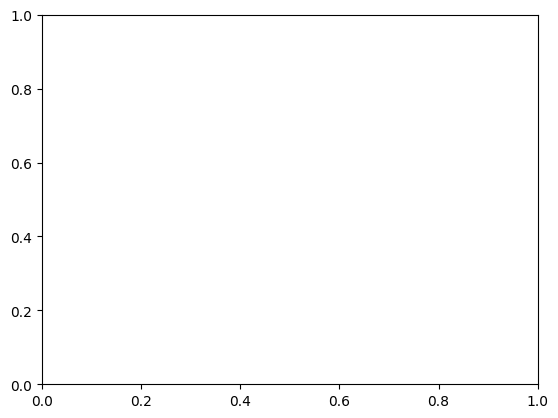

In [53]:
#   plot altogether - makes plot of subgroup (need to to manualy)
worms = "sexc_5"
filename = (
    "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/post-conditioning/him5/plots/plots_traj_state/hi-quality eps/grouped/"
    + worms
    + ".eps"
)

fig, ax = plt.subplots()
i = 1
for worm in sexc_worms[20:25]:
    this_worm = data_df[data_df["unique_id"] == worm]
    this_cmap = sequentials[i]
    ax.scatter(
        this_worm["coord_x_body"],
        this_worm["coord_y_body"],
        s=0.1,
        c=this_worm["frame_number"],
        cmap=this_cmap,
        marker=".",
    )

    # when re-run this make sure x_coord and y_coord min and max still within range set in function
    ax.set_xlim(left=0, right=46000)
    ax.set_ylim(bottom=0, top=46000)
    if i == 17:
        i = 1
    else:
        i += 1


plt.savefig(filename, transparent=True, format="eps")


# plt.savefig('destination_path.eps', format='eps')

In [ ]:
print(len(mock_worms))
print(len(avsv_worms))
print(len(sexc_worms))

## code to generate fwds_revs excel that allows analysis of fwd and rev lengtths using percentiles

In [58]:
mock_revs = true_rev_lengths["revlen"][
    true_rev_lengths["unique_id"].isin(mock_worms)
].reset_index(drop=True)
avsv_revs = true_rev_lengths["revlen"][
    true_rev_lengths["unique_id"].isin(avsv_worms)
].reset_index(drop=True)
sexc_revs = true_rev_lengths["revlen"][
    true_rev_lengths["unique_id"].isin(sexc_worms)
].reset_index(drop=True)


mock_fwds = all_fwd_lengths["fwdlen"][
    all_fwd_lengths["unique_id"].isin(mock_worms)
].reset_index(drop=True)
avsv_fwds = all_fwd_lengths["fwdlen"][
    all_fwd_lengths["unique_id"].isin(avsv_worms)
].reset_index(drop=True)
sexc_fwds = all_fwd_lengths["fwdlen"][
    all_fwd_lengths["unique_id"].isin(sexc_worms)
].reset_index(drop=True)


fwdsrevs = pd.DataFrame(
    {
        "mock_revs": pd.Series(mock_revs),
        "avsv_revs": pd.Series(avsv_revs),
        "sexc_revs": pd.Series(sexc_revs),
        "mock_fwds": pd.Series(mock_fwds),
        "avsv_fwds": pd.Series(avsv_fwds),
        "sexc_fwds": pd.Series(sexc_fwds),
    }
)
fwdsrevs


fwdsrevs.to_excel(outputdir + "fwdsrevs" + code + ".xlsx")

In [ ]:
fwdsrevs.quantile([0.25, 0.5, 0.75])

fwdsrevs.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# df.quantile([.1, .5])

In [ ]:
dfghjk

In [60]:
### for stats : get the deciles of mock reversal length, and tdhen the proportion of avsv an sexc reversals in each of those intervals

# REVERSALS

mockrevs = fwdsrevs["mock_revs"].values
avsvrevs = fwdsrevs["avsv_revs"].values
sexcrevs = fwdsrevs["sexc_revs"].values


revdf_bins = pd.DataFrame()
# Generate bins from control group
_, bins = pd.qcut(mockrevs, q=10, retbins=True)
revdf_bins["bin"] = pd.cut(mockrevs, bins=bins).value_counts().index


revdf_bins["mock_revs"] = pd.cut(mockrevs, bins=bins).value_counts().values
revdf_bins["avsv_revs"] = pd.cut(avsvrevs, bins=bins).value_counts().values
revdf_bins["sexc_revs"] = pd.cut(sexcrevs, bins=bins).value_counts().values


revdf_bins.to_excel(outputdir + "df_bins_reversals" + code + ".xlsx")

revdf_bins


# FORWARD RUNS
mockfwds = fwdsrevs["mock_fwds"].values
avsvfwds = fwdsrevs["avsv_fwds"].values
sexcfwds = fwdsrevs["sexc_fwds"].values


fwddf_bins = pd.DataFrame()
# Generate bins from control group
_, bins = pd.qcut(mockfwds, q=10, retbins=True)
fwddf_bins["bin"] = pd.cut(mockrevs, bins=bins).value_counts().index


fwddf_bins["mock_fwds"] = pd.cut(mockfwds, bins=bins).value_counts().values
fwddf_bins["avsv_fwds"] = pd.cut(avsvfwds, bins=bins).value_counts().values
fwddf_bins["sexc_fwds"] = pd.cut(sexcfwds, bins=bins).value_counts().values


fwddf_bins.to_excel(outputdir + "df_bins_forwards" + code + ".xlsx")

fwddf_bins

,bin,mock_fwds,avsv_fwds,sexc_fwds
0,"(1.0, 3.0]",90,60,313
1,"(3.0, 6.0]",97,55,423
2,"(6.0, 13.0]",128,99,382
3,"(13.0, 24.0]",116,70,178
4,"(24.0, 40.5]",121,84,130
5,"(40.5, 70.0]",125,108,152
6,"(70.0, 109.0]",122,103,115
7,"(109.0, 165.0]",124,104,83
8,"(165.0, 307.1]",121,120,92
9,"(307.1, 2934.0]",123,157,74


## get reversal length histo of true revlengths true revs

In [ ]:
true_fwd_lengths.describe()

In [ ]:
# reversal length histogram

fig, ax = plt.subplots()
ax.hist(true_rev_lengths["revlen"], bins=50)

ax.set_xlim(left=0, right=100)
ax.set_xticks([37.5, 52.5], minor=True)

ax.plot([35, 35], [0, 100], linewidth=0.5, color="r")
ax.plot([57.5, 57.5], [0, 100], linewidth=0.5, color="r")


# plt.savefig(
#     outputdir + "truerevlen_histo50" + code + ".png",
#     transparent=True,
# )


# # forward runs length histogram

# fig, ax = plt.subplots()
# ax.hist(all_fwd_lengths["fwdlen"], bins=50)

# ax.set_xlim(left=0, right=1000)
# # ax.set_xticks([37.5, 52.5], minor=True)

# # ax.plot([35, 35], [0, 100], linewidth=0.5, color="r")
# # ax.plot([57.5, 57.5], [0, 100], linewidth=0.5, color="r")


# # plt.savefig(
# #     outputdir + "truerevlen_histo50" + code + ".png",
# #     transparent=True,
# # )

## other

In [ ]:
# draft 2 revlen histos per cond

fig, ax = plt.subplots(3)
ax[0].hist(
    true_rev_lengths["revlen"][true_rev_lengths["unique_id"].isin(mock_worms)], bins=25
)
ax[0].set_xlim(left=0, right=100)


ax[1].hist(
    true_rev_lengths["revlen"][true_rev_lengths["unique_id"].isin(avsv_worms)], bins=25
)
ax[1].set_xlim(left=0, right=100)

ax[2].hist(
    true_rev_lengths["revlen"][true_rev_lengths["unique_id"].isin(sexc_worms)], bins=25
)
ax[2].set_xlim(left=0, right=100)

# ax[0].set_xticks(binss, labels=binss)
# ax[1].set_xticks(binss, labels=binss)
# ax[2].set_xticks(binss, labels=binss)


ax[0].set_ylim(bottom=0, top=40)
ax[1].set_ylim(bottom=0, top=40)
ax[2].set_ylim(bottom=0, top=40)

In [ ]:
# draft revlen histos per cond

binss = 
rangee = 

fig, ax = plt.subplots(3)
ax[0].hist(
    true_rev_lengths["revlen"][true_rev_lengths["unique_id"].isin(mock_worms)],
    bins=binss,
    range=rangee,
)

ax[0].set_xlim(left=0, right=60)

ax[1].hist(
    true_rev_lengths["revlen"][true_rev_lengths["unique_id"].isin(avsv_worms)],
    bins=binss,
    range=rangee,
)
ax[1].set_xlim(left=0, right=20)

ax[2].hist(
    true_rev_lengths["revlen"][true_rev_lengths["unique_id"].isin(sexc_worms)],
    bins=binss,
    range=rangee,
)
ax[2].set_xlim(left=0, right=20)

ax[0].set_xticks(binss, labels=binss)
ax[1].set_xticks(binss, labels=binss)
ax[2].set_xticks(binss, labels=binss)


ax[0].set_ylim(bottom=0, top=800)
ax[1].set_ylim(bottom=0, top=800)
ax[2].set_ylim(bottom=0, top=800)

### attempt plot violin of reversals per worm per min - doesnt work

In [ ]:
#violin accepts array of data, will make new violin for each COLUMN -- so need to get data into that format

#create numpy array w mock/avsv/sexc as columns, each row is R/min of 1 worm


In [ ]:
# create lists with unique_ids of each worm condition
mock_worms = data_df["unique_id"][data_df["cond"] == "mock"].unique()
avsv_worms = data_df["unique_id"][data_df["cond"] == "avsv"].unique()
sexc_worms = data_df["unique_id"][data_df["cond"] == "sexc"].unique()

mock_Rpm = feats_per_worm["R/min"][feats_per_worm["cond"] == "mock"]
avsv_Rpm = feats_per_worm["R/min"][feats_per_worm["cond"] == "avsv"]
sexc_Rpm = feats_per_worm["R/min"][feats_per_worm["cond"] == "sexc"]


fig, ax = plt.subplots()
ax.violinplot(mock_Rpm.to_numpy())

In [ ]:
rpm = np.concatenate((mock_Rpm.to_numpy(), avsv_Rpm.to_numpy(), sexc_Rpm.to_numpy()))
# rpm_array = rpm.to_numpy()

In [ ]:
rpm

In [ ]:
mock_Rpm

In [ ]:
rpm_array

In [ ]:
fig, ax = plt.subplots()
ax.violinplot(rpm_array)

In [ ]:
true_data = [np.random.normal(0, std, 100) for std in range(6, 10)]
true_data

In [ ]:
data_df[["unique_id", "coord_x_body"]]

#### general

### other

 column names list

In [ ]:
data_df.columns.values.tolist()

In [ ]:
data_df.loc[451800:451850, ["speed", "frame_number", "RevStart", "RevEnd", "unique_id"]]

In [ ]:
565 - 369

In [ ]:
testdf2 = pd.DataFrame()
testdfsmtrue = pd.DataFrame(
    data=[[1, "yes", 5], [2, "yes", 8], [3, "no", 3]],
    columns=[["index", "birthday passed", "age"]],
)

testdfsmtrue
testdfsmtrue[testdfsmtrue["age"] > 1]
# data_df[data_df["unique_id"] == 1]

# a = pd.concat([testdf2, testdfsmtrue[testdfsmtrue["birthday passed"] == "yes"]])
# b = testdfsmtrue[testdfsmtrue["birthday passed"] == "yes"]